# **Metro Map Style Diagram of Iceland Power Grid**

## Import Packages

In [2338]:

import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pyomo.environ import*
import math
import csv
from IPython.display import display

from pyproj import Transformer 
from itertools import combinations
from shapely.geometry import LineString

import matplotlib.lines as mlines

## Access Files

Creating Dataframe of particular country and particular links

In [2339]:
## Specified Country DataFrame
filename = 'IS.csv'

file_path = filename
country_df = pd.read_csv(file_path)

print(f"Shape of df is: {country_df.shape}")



## Add scaling factor if needed to the x y positions for graphing and optimisation
# Infeasible when x y values are too large

scaling_factor = 0.001

# Scale 'src_x' and 'src_y' columns
country_df['src_x'] = country_df['src_x'] * scaling_factor
country_df['src_y'] = country_df['src_y'] * scaling_factor

# Scale 'dst_x' and 'dst_y' columns
country_df['dst_x'] = country_df['dst_x'] * scaling_factor
country_df['dst_y'] = country_df['dst_y'] * scaling_factor

display(country_df)


Shape of df is: (39, 18)


,link_id,src_bus_id,dst_bus_id,voltage,circuits,dc,underground,under_construction,length_m,tags,src_coord,dst_coord,src_country,dst_country,src_x,src_y,dst_x,dst_y
0,9014,6093,6094,132.0,1,f,f,f,85606.056856,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-23.148193, 65.789264)","(-21.851807, 65.467386)",IS,IS,-2576.845058,9819.406494,-2432.532028,9732.573974
1,9015,6107,6127,132.0,1,f,f,f,8526.255555,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-22.554932, 63.980781)","(-22.5, 63.908396)",IS,IS,-2510.803545,9344.885400,-2504.688543,9326.540388
2,9008,6089,6126,132.0,1,f,f,f,84167.700312,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-18.182373, 65.68543)","(-16.896973, 65.703518)",IS,IS,-2024.052504,9791.277516,-1880.962430,9796.169489
3,9009,6124,6126,132.0,1,f,f,f,137912.853760,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-15.172119, 64.914228)","(-16.896973, 65.703518)",IS,IS,-1688.952561,9585.814971,-1880.962430,9796.169489
4,9013,6098,6124,132.0,1,f,f,f,26730.997512,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-14.688721, 65.030423)","(-15.172119, 64.914228)",IS,IS,-1635.140942,9616.389627,-1688.952561,9585.814971
5,9012,6102,6120,132.0,1,f,f,f,74921.825029,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-18.083496, 63.81644)","(-19.248047, 64.177679)",IS,IS,-2013.045566,9303.303493,-2142.682791,9395.027908
6,9033,6103,6116,132.0,1,f,f,f,40026.269114,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-21.719971, 64.086607)","(-21.049805, 64.081805)",IS,IS,-2417.856112,9371.791220,-2343.253574,9370.568119
7,9034,6127,6128,132.0,1,f,f,f,9487.765121,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-22.5, 63.908396)","(-22.302246, 63.903564)",IS,IS,-2504.688543,9326.540388,-2482.674668,9325.317468
8,9020,6103,6115,132.0,1,f,f,f,26071.470229,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-21.719971, 64.086607)","(-21.236572, 64.187249)",IS,IS,-2417.856112,9371.791220,-2364.044381,9397.474088
9,9032,6103,6114,132.0,1,f,f,f,10353.579975,'text_'=>' ' 'symbol'=>'132-150 kV Transmissi...,"(-21.719971, 64.086607)","(-21.708984, 64.177679)",IS,IS,-2417.856112,9371.791220,-2416.633045,9395.027908


# NetworkX Set Up

## Functions - pre NetworkX

In [2340]:
def calculate_forward_sector(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    
    # Angle in radians
    angle_rad = math.atan2(dy, dx)
    
    # Convert to degreees
    angle_deg = math.degrees(angle_rad)
    
    # Angle is rounded to nearest multiple of 45
    # Sector value calculated, modulo 8 used 
    sector = round(angle_deg / 45) % 8
    
    return sector




def euclidean_distance(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    
    return math.sqrt((dx)**2 + (dy)**2)






def calculate_angle(src_x, src_y, dst_x, dst_y):
    dx = dst_x - src_x
    dy = dst_y - src_y
    angle_radians = math.atan2(dy, dx)
    angle_degrees = math.degrees(angle_radians)  # Convert the angle to degrees
    
    # Normalize the angle to be within 0 to 360 degrees
    angle_degrees = (angle_degrees + 360) % 360

    return angle_degrees




## NetworkX Implementation
Dataframe is accessed where nodes and edges are added to graph. 
Forward and backward sector of a particular edge are found and stored as attributes along with the voltage information.

In [2341]:

# Initialize a directed graph since we have source and destination
G = nx.DiGraph()

# Loop through the DataFrame rows to add edges and nodes to the graph
for index, row in country_df.iterrows():
    src_node = row['src_bus_id']
    dst_node = row['dst_bus_id']
    voltage = row['voltage']
    
    # Add the source and destination nodes if they don't already exist
    if src_node not in G:
        G.add_node(src_node, pos=(row['src_x'], row['src_y']))
    if dst_node not in G:
        G.add_node(dst_node, pos=(row['dst_x'], row['dst_y']))
        
        
        
    # Calculate the forward sector for edges
    forward_sector = calculate_forward_sector(row['src_x'], row['src_y'], row['dst_x'], row['dst_y'])

    # Backward sector
    backward_sector = (forward_sector + 4) % 8
    
    distance = euclidean_distance(row['src_x'], row['src_y'], row['dst_x'], row['dst_y'])
    
    # Add an edge between the source and destination nodes, voltage is attribute
    G.add_edge(src_node, dst_node, 
               voltage = voltage, 
               forward_sector = forward_sector, 
               backward_sector = backward_sector,
               distance = distance
               )




 

## Functions - Access particular details from graph

In [2342]:


def get_non_incident_edge_pairs(G):
    non_incident_edge_pairs = []
    
    # combinations - generates all possible pairs of edges from graph G without repeating the same pair
    # '2' indicates we're looking for combinationes of 2 edges
    for edge1, edge2 in combinations(G.edges(), 2):
        
        # edges are sets and the '&' checks that they have no common elements (ie nodes)
        if not set(edge1) & set(edge2):
            non_incident_edge_pairs.append((edge1, edge2))
    return non_incident_edge_pairs    






 
def get_filtered_neighbour_order(G):
    
    # Convert the directed graph to an undirected graph to consider all adjacent nodes as neighbours
    G_undirected = G.to_undirected()
    
    # Create Dictionary to story nodes neighbour orders
    neighbour_order = {}
    for node in G_undirected.nodes():
        
        # Check if the node has 2 or more neighbours
        if G_undirected.degree(node) >= 2:
        
            # Access the position of the current node
            src_pos = G_undirected.nodes[node]['pos']
            src_x, src_y = src_pos
            
            # Create list to store angle size of neighbours with src node
            angles_neighbours = []
            
            
            
            for neighbour in G_undirected.neighbors(node):
                # Access the position tuple of the neighbour node using the 'pos' attribute
                dst_pos = G_undirected.nodes[neighbour]['pos']
                dst_x, dst_y = dst_pos
                
                # Calculate the angle from the source node to the neighbour node
                angle = calculate_angle(src_x, src_y, dst_x, dst_y)
                
                # Append the angle and neighbour to the list
                angles_neighbours.append((angle, neighbour)) 
                
                
            
            # Sort the list of (angle, neighbour) pairs by angle in ascending order
            angles_neighbours.sort()
            
            # Extract the sorted neighbours from the sorted list of pairs
            sorted_neighbours = [neighbour for _, neighbour in angles_neighbours]
            
            # Check conditions to move the last neighbour to the first position
            if angles_neighbours[-1][0] > 315 and ((360 - angles_neighbours[-1][0]) < angles_neighbours[0][0]):
                # Move the last neighbour to the first position
                sorted_neighbours.insert(0, sorted_neighbours.pop())
            
            
            # Store the sorted list of neighbours in the dictionary with the src_node as the key
            neighbour_order[node] = sorted_neighbours
    
    return neighbour_order


# Gets values of the dictionary for particular node
def get_neighbors_for_node(node_id, ordered_neighbors_dict):
    return ordered_neighbors_dict.get(node_id)
   

Create List and Dictionary of non incident edge pairs and the ordering of neighbour nodes around a node

In [2343]:
# Create list of non-incident edge pairs
non_incident_edge_pairs = get_non_incident_edge_pairs(G)

# Create Dictionary of circular order neighours of each node
ordered_neighbours_dict = get_filtered_neighbour_order(G)


print(ordered_neighbours_dict)  



def generate_node_triples(ordered_neighbours_dict):
    
    triplets = set()  # Use a set to avoid duplicates
    for node, neighbours in ordered_neighbours_dict.items():
        
        if len(neighbours) > 1:  # Ensure there are at least two neighbours to form a triplet
            num_neighbours = len(neighbours)
            
            for i in range(num_neighbours):
                # Create triplets by taking the current node and the next two nodes in a circular manner
                first_neighbour = neighbours[i]
                second_neighbour = neighbours[(i + 1) % num_neighbours]  # Wrap around using modulo
                triplets.add((node, first_neighbour, second_neighbour))
                triplets.add((node, second_neighbour, first_neighbour))  # Add the reverse order as well
    return triplets

node_neighbour_triplets = generate_node_triples(ordered_neighbours_dict)

""" # Printing the generated triplets
for triplet in triplets:
    print(triplet) """

 
# Function to print specific triplets
def print_specific_triplets(node_neighbour_triplets, node):
    print(f"Triplets starting with node {node}:")
    for triplet in node_neighbour_triplets:
        if triplet[0] == node:
            print(triplet)

# Call the function to print triplets where the first node is 6094
print_specific_triplets(node_neighbour_triplets, 6094)


# Debugging 
""" 
# Print non-incident edge pairs
print("Non-incident edge pairs:")
for edge_pair in non_incident_edge_pairs:
    print(edge_pair)


print("\nNodes with more than 2 neighbours ordered:")
print(ordered_neighbours_dict)
for node, neighbours in ordered_neighbours_dict.items():
    print(len(neighbours)) """
    
    

{6094: [6093, 6092], 6107: [6105, 6127], 6127: [6128, 6107, 6129], 6089: [6126, 6097], 6126: [6089, 6124], 6124: [6111, 6098, 6126], 6098: [6099, 6124, 6100], 6102: [6101, 6120], 6120: [6102, 6118, 6119, 6123], 6103: [6116, 6115, 6114, 6108, 6105], 6116: [6123, 6103], 6115: [6114, 6103], 6114: [6115, 6103], 6097: [6089, 6112], 6112: [6097, 6095], 6095: [6096, 6112], 6096: [6095, 6092, 6110], 6110: [6096, 6108], 6105: [6123, 6103, 6113, 6107], 6092: [6096, 6094], 6101: [6100, 6102], 6100: [6098, 6101], 6108: [6122, 6110, 6103], 6123: [6120, 6122, 6116, 6105], 6122: [6119, 6108, 6123], 6119: [6122, 6120]}
Triplets starting with node 6094:
(6094, 6092, 6093)
(6094, 6093, 6092)


' \n# Print non-incident edge pairs\nprint("Non-incident edge pairs:")\nfor edge_pair in non_incident_edge_pairs:\n    print(edge_pair)\n\n\nprint("\nNodes with more than 2 neighbours ordered:")\nprint(ordered_neighbours_dict)\nfor node, neighbours in ordered_neighbours_dict.items():\n    print(len(neighbours)) '

## Drawing NetworkX Graph

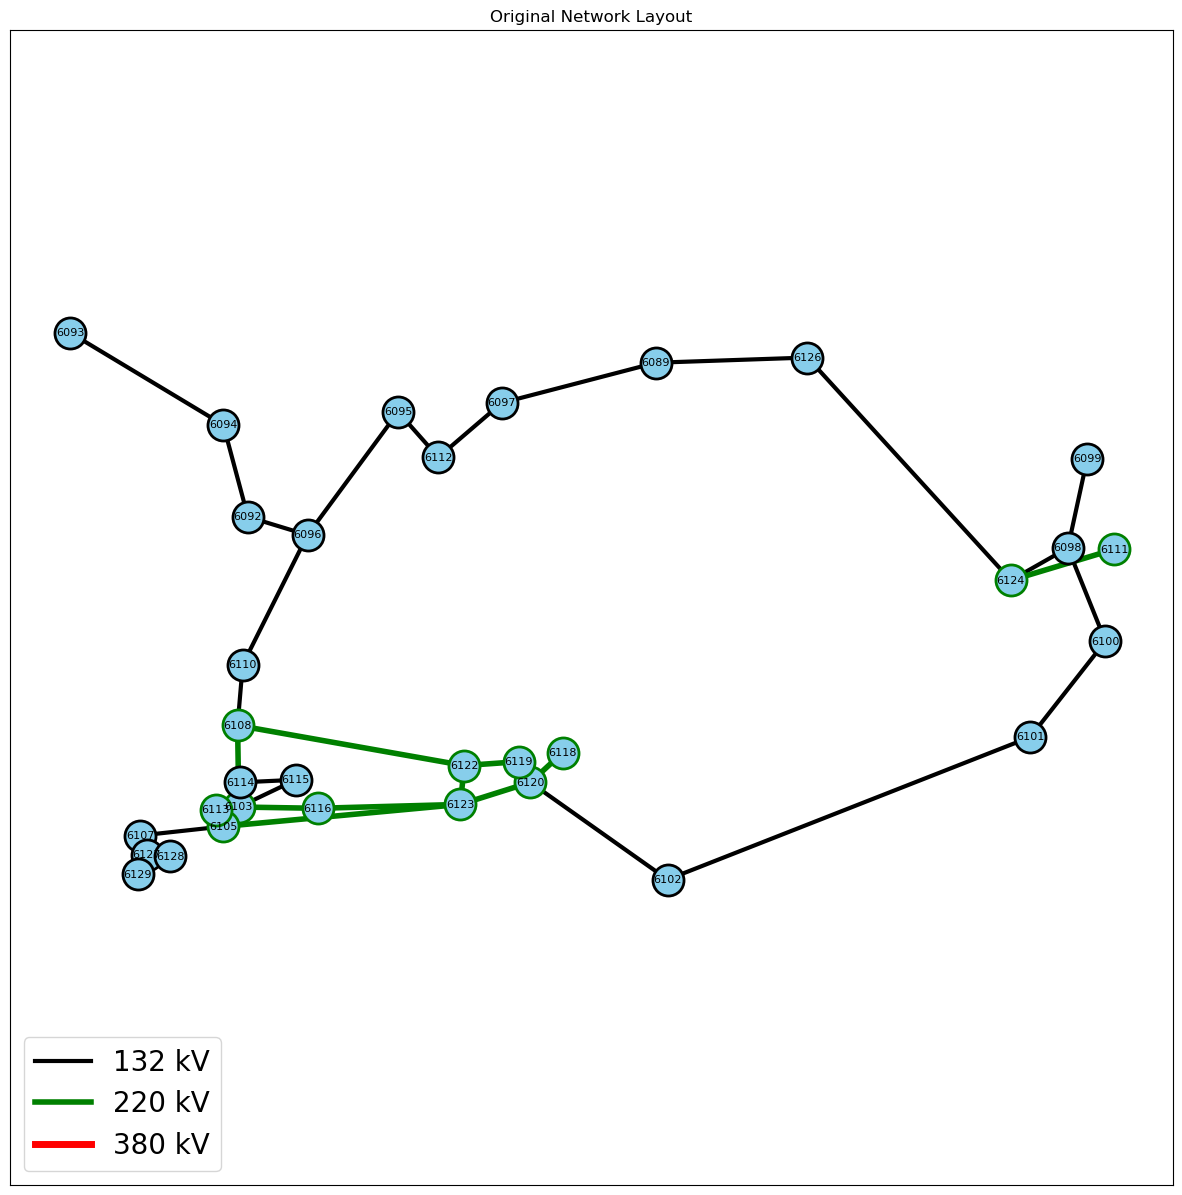

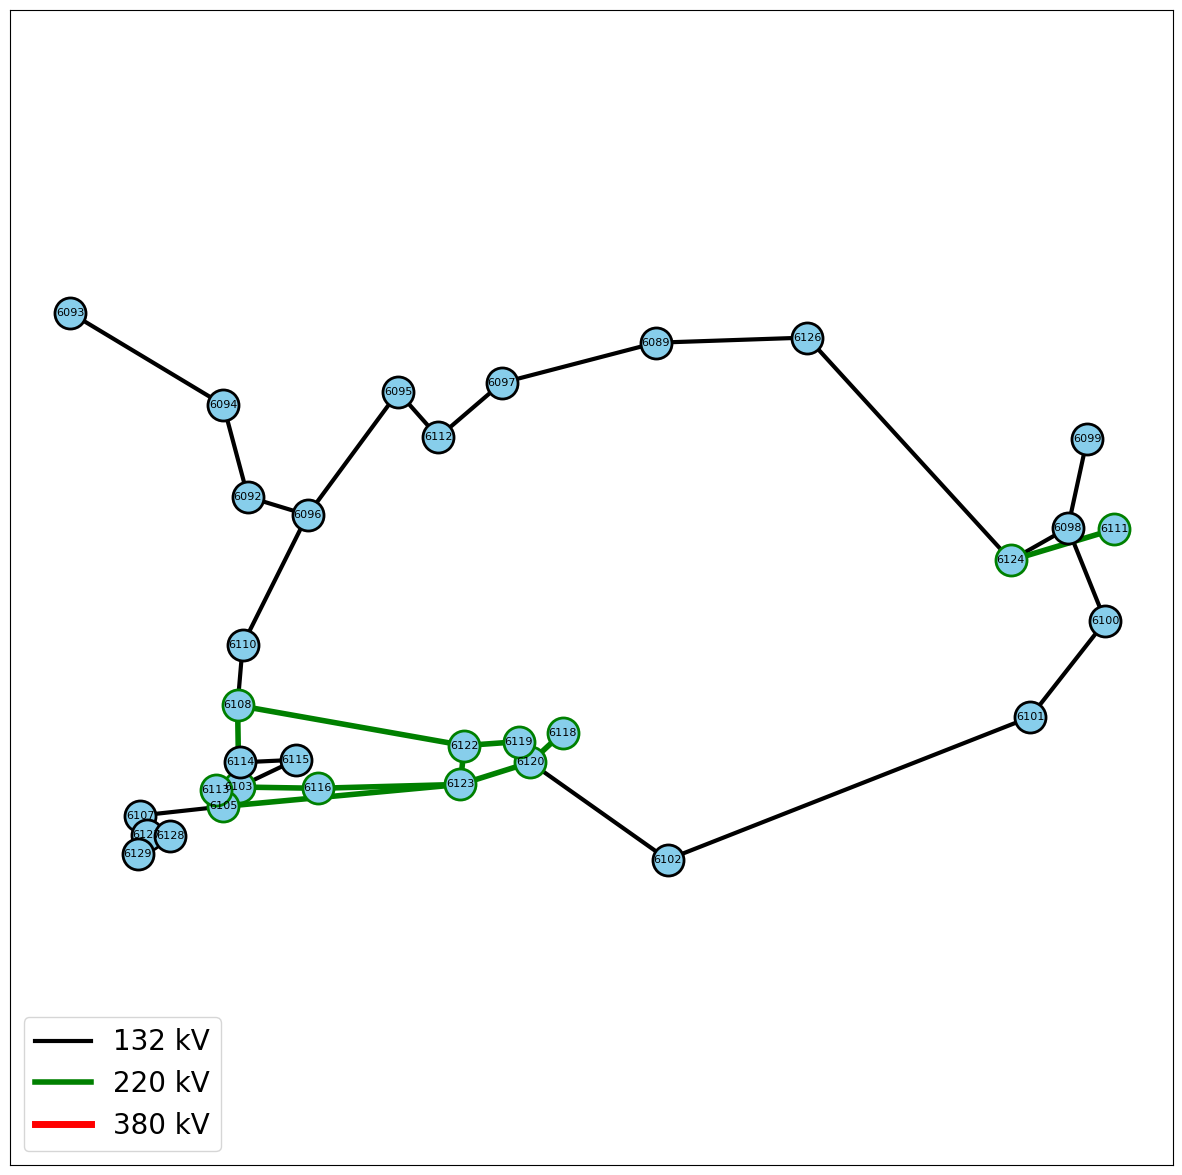

In [2344]:


pos = nx.get_node_attributes(G, 'pos')

 
## Function to Draw Graph
 
def draw_graph(G, pos, violations = None, ax=None, title=None):
    
    if violations is None:
        violations = []  # Initialize to an empty list if no violations are provided

    if ax is None:
        # Creating a new figure if no axis is provided
        fig, ax = plt.subplots(figsize=(15, 15))
    
    ax.set_title(title)
    
    # Convert to undirected graph for the purpose of finding node outline colors
    G_undirected = G.to_undirected()

    voltage_colors = {
        132: 'black',
        220: 'green',
        380: 'red',
        300: 'orange',
        500: 'yellow',
        750: 'purple'
    }

    # Determine the highest voltage color for each node
    node_outline_color = {}
    for node in G.nodes():
        connected_edges = G_undirected.edges(node, data=True)
        highest_voltage = max((data['voltage'] for _, _, data in connected_edges), default=0)
        node_outline_color[node] = voltage_colors.get(highest_voltage, 'grey')

    # Draw nodes with highest voltage outline color
    for node, color in node_outline_color.items():
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='skyblue',
                               edgecolors=color, node_size=500, linewidths=2, ax=ax)




    # Draw the graph edges with different colors based on the voltage
    for (u, v, d) in G.edges(data=True): 
        is_violation = (u,v) in violations or (v,u) in violations
        
        if is_violation:
            line_style = 'dashed'
        else: 
            line_style = 'solid'
        
        
        
        
        if d['voltage'] == 132:
            edge_color = 'black'
            line_width = 3
        elif d['voltage'] == 220:
            edge_color = 'green'
            line_width = 4
            
        elif d['voltage'] == 300:
            edge_color = 'orange'
            line_width = 4
        elif d['voltage'] == 380:
            edge_color = 'red'
            line_width = 5
        elif d['voltage'] == 500:
            edge_color = 'yellow'
            line_width = 5
        elif d['voltage'] == 750:
            edge_color = 'purple'
            line_width = 5.5
        else:
            edge_color = 'grey'  # Default color for unspecified or unknown voltages
            line_width = 3
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=edge_color, width=line_width, style = line_style, arrows=False, ax=ax)

    # Draw the node labels
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # Create edge labels for voltages, using 'link_id' or another attribute if desired
    edge_labels = nx.get_edge_attributes(G, 'link_id')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=7, ax=ax)

    # Define custom lines for the legend with appropriate colors and labels for each voltage level
    legend_lines = [
        mlines.Line2D([], [], color='black', markersize=30, label='132 kV', linewidth=3),
        mlines.Line2D([], [], color='green', markersize=30, label='220 kV', linewidth=4),
        mlines.Line2D([], [], color='red', markersize=30, label='380 kV', linewidth=5)
    ]
    """ mlines.Line2D([], [], color='orange', markersize=30, label='300 kV', linewidth=4),
    
    mlines.Line2D([], [], color='yellow', markersize=30, label='500 kV', linewidth=5),
    mlines.Line2D([], [], color='purple', markersize=30, label='750 kV', linewidth=5.5) """
    # Add the legend to the plot with all line types
    ax.legend(handles=legend_lines, loc='lower left', fontsize=20)
    ax.axis('equal')
    ax.grid(False)

    # Show the plot if ax was not provided
    if ax is None:
        plt.show()
        
draw_graph(G, pos, title="Original Network Layout")
draw_graph(G, pos)

## Access edge information from NetworkX Graph

In [2345]:
def get_edge_info(G, edge):
    node1, node2 = edge
    
    # edge attributes eg voltage forward/backward sector are stored in edge data
    edge_data = G.get_edge_data(node1, node2)
    
    # Additional edge information
    edge_information = {
        'edge': edge,
        'source': node1,
        'destination': node2,
        'source_position': G.nodes[node1].get('pos'),
        'destination_position': G.nodes[node2].get('pos'),
        'source_neighbors': list(G.successors(node1)),  # or list(G.successors(u)) for DiGraph
        'destination_neighbors': list(G.predecessors(node2)),  # or list(G.predecessors(v)) for DiGraph
        'source_degree': G.degree(node1),
        'destination_degree': G.degree(node2)
    }
    
    # Merge edge_data into edge_info
    edge_information.update(edge_data)
    return edge_information

    
# Debugging
# Print Specified Edge Details

""" edge_details = {}
for edge in G.edges():
    edge_details[edge] = get_edge_info(G, edge)
    print(edge_details[edge])
    
    forward = edge_details[edge].get('forward_sector')
    backward = edge_details[edge].get('backward_sector')
    print(f"Forward sector for edge {edge}: {forward}")
    print(f"Backward sector for edge {edge}: {backward}\n")  """
    


' edge_details = {}\nfor edge in G.edges():\n    edge_details[edge] = get_edge_info(G, edge)\n    print(edge_details[edge])\n    \n    forward = edge_details[edge].get(\'forward_sector\')\n    backward = edge_details[edge].get(\'backward_sector\')\n    print(f"Forward sector for edge {edge}: {forward}")\n    print(f"Backward sector for edge {edge}: {backward}\n")  '

In [2346]:

""" 
# Example of how to use this function:
node_id = 6120  # Specify the node ID for which you want to access neighbors
neighbors = get_neighbors_for_node(node_id, ordered_neighbours_dict)  # Assuming ordered_neighbours_dict is already defined

if neighbors is not None:
    print(f"Neighbors of node {node_id}: {neighbors}")
else:
    print(f"No neighbors listed for node {node_id}.") """

' \n# Example of how to use this function:\nnode_id = 6120  # Specify the node ID for which you want to access neighbors\nneighbors = get_neighbors_for_node(node_id, ordered_neighbours_dict)  # Assuming ordered_neighbours_dict is already defined\n\nif neighbors is not None:\n    print(f"Neighbors of node {node_id}: {neighbors}")\nelse:\n    print(f"No neighbors listed for node {node_id}.") '

Create Dictionary of initial lengths of each edge

In [2347]:
initial_lengths = {}

for edge in G.edges():
    edge_info = get_edge_info(G, edge)  # Retrieve edge information

    # Assuming the 'get_edge_info' function returns a dictionary with the positions
    node1_pos = edge_info.get('source_position')  # Source position (x, y)
    node2_pos = edge_info.get('destination_position')  # Destination position (x, y)

    # Calculate the Euclidean distance between node1 and node2
    distance = euclidean_distance(node1_pos[0], node1_pos[1], node2_pos[0], node2_pos[1])

    # Store the distance in the initial_lengths dictionary using the edge as the key
    initial_lengths[edge] = distance

print(initial_lengths)    



## Details of Edge Lengths
# Calculate min, max, and average lengths
min_length = min(initial_lengths.values())
max_length = max(initial_lengths.values())
avg_length = sum(initial_lengths.values()) / len(initial_lengths)

print("\nMinimum Length:", min_length)
print("\nMaximum Length:", max_length)
print("\nAverage Length:", avg_length)

{(6093, 6094): 168.4224953736467, (6107, 6127): 19.337340078383743, (6127, 6128): 22.047816386893928, (6127, 6129): 20.244176262576545, (6089, 6126): 143.17367258665433, (6089, 6097): 150.39324372348787, (6124, 6126): 284.81013504305605, (6098, 6124): 61.89103295366548, (6098, 6100): 94.92968540453163, (6098, 6099): 86.35755360401282, (6102, 6120): 158.80547299139502, (6120, 6123): 69.23695827360343, (6103, 6116): 74.61256350965384, (6103, 6115): 59.62643744586638, (6103, 6114): 23.268853913842012, (6103, 6108): 77.05817105889444, (6103, 6105): 23.493004843798637, (6116, 6123): 134.5791799499478, (6114, 6115): 52.64552499347177, (6097, 6112): 78.92799423554511, (6095, 6112): 57.18064958612541, (6095, 6096): 144.31842571319837, (6096, 6110): 136.73462715081703, (6105, 6107): 78.73828893763937, (6105, 6123): 224.77122961774324, (6105, 6113): 17.51067813689636, (6092, 6094): 89.88787964295598, (6092, 6096): 58.805481423187025, (6101, 6102): 367.91554379694054, (6100, 6101): 114.9873242671

# Functions - Optimisation

### Octilinearity Constraints Functions
- Getting Dynamic Minimum Edge Length

In [2348]:
def calculate_dynamic_min_lengths(G, avg_length, std_length):
    dynamic_min_lengths = {}
    
    # Get the maximum degree in the graph to normalize the local density
    max_degree = max(deg for node, deg in G.degree())

    # Iterate through each edge in the graph G
    for edge in G.edges():
        # Get the detailed information for the current edge
        edge_info = get_edge_info(G, edge)

        # Use the degree of nodes as a proxy for local density
        local_density = edge_info['source_degree'] + edge_info['destination_degree']
        
        # Scale the density factor non-linearly to increase variability
        # subtract from 1 ensures that higher density leads to shorter lengths
        density_factor = 1 - math.sqrt(local_density / (1 * max_degree))
        
        # Apply the adjustment based on local density and standard deviation
        adjusted_length = avg_length + std_length * density_factor
        
        # Ensure that the adjusted length is not below some minimum threshold if necessary
        min_threshold = avg_length * 0.5  #at least 50% of the average length
        adjusted_length = max(adjusted_length, min_threshold)
        
        # Store the adjusted length
        dynamic_min_lengths[edge] = adjusted_length

    return dynamic_min_lengths

# Calculate the average and standard deviation of the initial edge lengths
lengths = [euclidean_distance(*G.nodes[edge[0]]['pos'], *G.nodes[edge[1]]['pos']) for edge in G.edges()]
avg_length = np.mean(lengths)
std_length = np.std(lengths)

print(f"Avg Length: {avg_length}")

# Use the function with the graph G
dynamic_min_edge_length_dict = calculate_dynamic_min_lengths(G, avg_length, std_length)
print(dynamic_min_edge_length_dict )

Avg Length: 97.95322440936245
{(6093, 6094): 115.31948860619933, (6107, 6127): 97.95322440936245, (6127, 6128): 106.08711172561448, (6127, 6129): 106.08711172561448, (6089, 6126): 106.08711172561448, (6089, 6097): 106.08711172561448, (6124, 6126): 97.95322440936245, (6098, 6124): 90.59962817815732, (6098, 6100): 97.95322440936245, (6098, 6099): 106.08711172561448, (6102, 6120): 90.59962817815732, (6120, 6123): 77.5430755806944, (6103, 6116): 83.8372985398084, (6103, 6115): 83.8372985398084, (6103, 6114): 83.8372985398084, (6103, 6108): 77.5430755806944, (6103, 6105): 71.63141213264754, (6116, 6123): 90.59962817815732, (6114, 6115): 106.08711172561448, (6097, 6112): 106.08711172561448, (6095, 6112): 106.08711172561448, (6095, 6096): 97.95322440936245, (6096, 6110): 97.95322440936245, (6105, 6107): 90.59962817815732, (6105, 6123): 77.5430755806944, (6105, 6113): 97.95322440936245, (6092, 6094): 106.08711172561448, (6092, 6096): 97.95322440936245, (6101, 6102): 106.08711172561448, (6100, 

### Circular Vertex Order Constraints Functions

In [2349]:
## Function to get index of nodes in the ordered neighbours list.

# This function initializes the set of (node, index) pairs, where 'node' is a node with 2 or more neighbors,
# and 'index' is a unique integer (starting from 1) representing the position of a neighbor in the
# counterclockwise ordering of neighbors around 'node'.

""" def node_neighbour_index_pairs_init(model):
    node_index_pairs = []
    for node, neighbors in ordered_neighbours_dict.items():
        # Start index from 0 for each node's neighbors
        for idx in range(0, len(neighbors)):
            node_index_pairs.append((node, idx))
    return node_index_pairs """



## Helper Function for the circular vertex order
## Determines if node with more than 2 neighbours is the source or destination node
## So the correct direction can be assigned to it
def orig_sector(model, node, neighbor):
    if (node, neighbor) in model.Edges:
        return model.sect_forward[node, neighbor]
    elif (neighbor, node) in model.Edges:
        return model.sect_backward[neighbor, node]
    else:
        return None 

def node_neighbour_direction(model, node, neighbor):
    if (node, neighbor) in model.Edges:
        return model.dir_forward[node, neighbor]
    elif (neighbor, node) in model.Edges:
        return model.dir_backward[neighbor, node]
    else:
        return None  

### Edge Spacing Constraints Functions
Gets list of intersecting edges and new list of non intersecting non incident edges created

In [2350]:


def list_edge_intersections(G):
    intersecting_edge_pairs = []
    non_incident_edge_pairs = get_non_incident_edge_pairs(G)

    for edge1, edge2 in non_incident_edge_pairs:
        # Get the positions for the source and target nodes of each edge
        src_pos1, tgt_pos1 = G.nodes[edge1[0]]['pos'], G.nodes[edge1[1]]['pos']
        src_pos2, tgt_pos2 = G.nodes[edge2[0]]['pos'], G.nodes[edge2[1]]['pos']
        
        # Create LineString objects for each edge
        line1 = LineString([src_pos1, tgt_pos1])
        line2 = LineString([src_pos2, tgt_pos2])

        # Check if the two edges intersect
        if line1.intersects(line2):
            # If they intersect, add the edge pair to the list
            intersecting_edge_pairs.append((edge1, edge2))

    return intersecting_edge_pairs

# Call the function to get intersecting edge pairs
intersecting_edges = list_edge_intersections(G)

# Print the intersecting edge pairs
for edge_pair in intersecting_edges:
    print(f"Intersecting Edge Pair: {edge_pair}")

Intersecting Edge Pair: ((6098, 6100), (6111, 6124))


In [2351]:
def calculate_dynamic_min_spacings(G):
    dynamic_min_spacings = {}
    spacings = []

    # Calculate initial spacings using the euclidean_distance function
    for edge in G.edges():
        edge_info = get_edge_info(G, edge)
        src_x, src_y = edge_info['source_position']
        dst_x, dst_y = edge_info['destination_position']
        spacing = euclidean_distance(src_x, src_y, dst_x, dst_y)
        spacings.append(spacing)
    
    # Calculate average and standard deviation of spacings
    avg_spacing = sum(spacings) / len(spacings)
    std_spacing = math.sqrt(sum((x - avg_spacing)**2 for x in spacings) / len(spacings))

    # Get the maximum degree in the graph to normalize the local density
    max_degree = max(deg for node, deg in G.degree())

    # Adjust spacings based on local density and incorporate std deviation
    for edge in G.edges():
        edge_info = get_edge_info(G, edge)
        local_density = edge_info['source_degree'] + edge_info['destination_degree']
        density_factor = 1 - math.sqrt(local_density / (1 * max_degree))
        
        # Use standard deviation to modulate the density factor dynamically
        adjusted_spacing = (avg_spacing + std_spacing * density_factor) * (1 - density_factor)
        min_threshold = avg_spacing * 0.3  # Ensure at least 30% of the average spacing
        adjusted_spacing = max(adjusted_spacing, min_threshold)
        
        dynamic_min_spacings[edge] = adjusted_spacing

    return dynamic_min_spacings

dynamic_min_spacings = calculate_dynamic_min_spacings(G)
print(dynamic_min_spacings)


{(6093, 6094): 89.32609177299322, (6107, 6127): 97.95322440936248, (6127, 6128): 94.88719734203562, (6127, 6129): 94.88719734203562, (6089, 6126): 94.88719734203562, (6089, 6097): 94.88719734203562, (6124, 6126): 97.95322440936248, (6098, 6124): 99.2469201095149, (6098, 6100): 97.95322440936248, (6098, 6099): 94.88719734203562, (6102, 6120): 99.2469201095149, (6120, 6123): 98.08509424383128, (6103, 6116): 99.19762939220952, (6103, 6115): 99.19762939220952, (6103, 6114): 99.19762939220952, (6103, 6108): 98.08509424383128, (6103, 6105): 96.1036241117419, (6116, 6123): 99.2469201095149, (6114, 6115): 94.88719734203562, (6097, 6112): 94.88719734203562, (6095, 6112): 94.88719734203562, (6095, 6096): 97.95322440936248, (6096, 6110): 97.95322440936248, (6105, 6107): 99.2469201095149, (6105, 6123): 98.08509424383128, (6105, 6113): 97.95322440936248, (6092, 6094): 94.88719734203562, (6092, 6096): 97.95322440936248, (6101, 6102): 94.88719734203562, (6100, 6101): 94.88719734203562, (6108, 6110): 

In [2352]:
# Create a new list excluding intersecting edge pairs
non_intersecting_non_incident_edges = [edge_pair for edge_pair in non_incident_edge_pairs if edge_pair not in intersecting_edges]

# Print the new list of non-intersecting, non-incident edge pairs
""" for edge_pair in non_intersecting_non_incident_edges:
    print(f"Non-Intersecting Non-Incident Edge Pair: {edge_pair}") """

' for edge_pair in non_intersecting_non_incident_edges:\n    print(f"Non-Intersecting Non-Incident Edge Pair: {edge_pair}") '

# Optimisation

## Variables and Parameters

In [2353]:

model = ConcreteModel()

model.Nodes = Set(initialize = list(G.nodes()))
model.Edges = Set(initialize = list(G.edges()))







model.NonIncidentEdges = Set(initialize = non_incident_edge_pairs, dimen=4)
model.NonIntersecting_NonIncidentEdges = Set(initialize = non_intersecting_non_incident_edges, dimen=4)
model.IntersectingEdgePairs = Set(initialize = intersecting_edges, dimen = 4)




# Set with 2 or more neighbours
# Storing set nodes with 2 or more neighbours that were predetermined in the dictionary
model.NodesWith2Neighbours = Set(initialize = ordered_neighbours_dict.keys())


model.NodeTriplets = Set(dimen=3, initialize=node_neighbour_triplets)









# Param to store the ordered neighbors for each node in the model
model.OrderedNeighbours = Param(
    model.NodesWith2Neighbours,  # Index set for the Param, representing nodes with 2 or more neighbors
    within=Any,  # Specifies that the Param can hold any type of data, in this case, tuples of nodes
    initialize=lambda model, node: tuple(ordered_neighbours_dict[node])  # Initialization function
    # lambda function takes 2 arguments model and node (element from set Nodewith2Neigbours)
    # for each node, it gets the list or ordered neighbours from the dictionary
    # list is converted to tuple so that for Param, the contents are unchangeable
)

model.Beta = Var(model.NodesWith2Neighbours, RangeSet(0, 7), within=Binary)













### PARAM ###
## Param - fixed value in model that doesn't change during optimisation process ##
# pos defined earlier as tuple (x, y) in graph G
model.x_init = Param(model.Nodes, initialize={node: pos[node][0] for node in G.nodes()})
model.y_init = Param(model.Nodes, initialize={node: pos[node][1] for node in G.nodes()})


# Access information from dictionary of the edge info
edge_info = {edge: get_edge_info(G, edge) for edge in G.edges()}

# Initialize Params for static attributes from the edges
model.voltage = Param(model.Edges, initialize={edge: edge_info[edge]['voltage'] for edge in model.Edges})
model.sect_forward = Param(model.Edges, initialize={edge: edge_info[edge]['forward_sector'] for edge in model.Edges})
model.sect_backward = Param(model.Edges, initialize={edge: edge_info[edge]['backward_sector'] for edge in model.Edges})
model.distance = Param(model.Edges, initialize={edge: edge_info[edge]['distance'] for edge in model.Edges} )


model.dynamicMinLengths = Param(model.Edges, within=NonNegativeReals, initialize=dynamic_min_edge_length_dict)
model.dynamicMinSpacings = Param(model.Edges, within=NonNegativeReals, initialize=dynamic_min_spacings)










### VARIABLES ###
## Define Variables ##
model.x_pos = Var(model.Nodes, within = Reals, initialize = model.x_init)
model.y_pos = Var(model.Nodes, within = Reals, initialize = model.y_init)

model.dir_forward = Var(model.Edges, within = Integers, bounds = (0, 7))
model.dir_backward = Var(model.Edges, within = Integers, bounds = (0, 7))


# Binary variable for octilinear constraint to determine where edge is drawn
model.alpha_pred = Var(model.Edges, within = Binary, bounds = (0, 1))
model.alpha_orig = Var(model.Edges, within = Binary, bounds = (0, 1))
model.alpha_succ = Var(model.Edges, within = Binary, bounds = (0, 1))




model.bend_cost = Var(model.NodeTriplets, within=NonNegativeIntegers)
#model.BendCost_neg = Var(model.Nodes, model.Nodes, model.Nodes, within=NonNegativeIntegers)


model.Delta1 = Var(model.NodeTriplets, within=Binary)
model.Delta2 = Var(model.NodeTriplets, within=Binary)



model.rpos = Var(model.Edges, within=NonNegativeReals)




model.edge_length_bound = Var(model.Edges, within = NonNegativeReals)

# Binary Variable for non-incident edge constraint
model.is_N = Var(model.NonIncidentEdges, within=Binary)
model.is_S = Var(model.NonIncidentEdges, within=Binary)
model.is_E = Var(model.NonIncidentEdges, within=Binary)
model.is_W = Var(model.NonIncidentEdges, within=Binary)
model.is_NE = Var(model.NonIncidentEdges, within=Binary)
model.is_NW = Var(model.NonIncidentEdges, within=Binary)
model.is_SE = Var(model.NonIncidentEdges, within=Binary)
model.is_SW = Var(model.NonIncidentEdges, within=Binary)


## Octilinearity Constraint

In [2354]:
# Sum of Binary variables is equal to 1
# node1 and node2 are the src and dst nodes defined in model.Edges
def alpha_direction_constraint(model, node1, node2):
    return model.alpha_pred[node1, node2] + model.alpha_orig[node1, node2] + model.alpha_succ[node1, node2] == 1
model.alpha_direction_constraint = Constraint(model.Edges, rule = alpha_direction_constraint, doc = "Alpha Binary Constraint")


 
 # for each edge in tuple (node1, node2) in model.Edges, dir constraint is called and formed
def dir_forward_constraint(model, node1, node2):
    
    
    sect_forward_pred = (model.sect_forward[node1, node2] - 1) % 8
    sect_forward_orig = model.sect_forward[node1, node2]
    sect_forward_succ = (model.sect_forward[node1, node2] + 1) % 8
    
    
    
    
    return model.dir_forward[node1, node2] == ((sect_forward_pred * model.alpha_pred[node1, node2]) +
                                        (sect_forward_orig * model.alpha_orig[node1, node2]) +
                                        (sect_forward_succ * model.alpha_succ[node1, node2])
                                        )

model.DirForwardConstraint = Constraint(model.Edges, rule=dir_forward_constraint, doc = "Dir forward constraint")
 

def dir_backward_constraint(model, node1, node2):
    sect_backward_pred = (model.sect_backward[node1, node2] - 1) % 8
    sect_backward_orig = model.sect_backward[node1, node2]
    sect_backward_succ = (model.sect_backward[node1, node2] + 1) % 8
    
      
    
    return model.dir_backward[node1, node2] == ((sect_backward_pred * model.alpha_pred[node1, node2]) +
                                        (sect_backward_orig * model.alpha_orig[node1, node2]) +
                                        (sect_backward_succ * model.alpha_succ[node1, node2])
                                        )
    
model.DirBackwardConstraint = Constraint(model.Edges, rule = dir_backward_constraint, doc = "Dir back Constraint") 




 
def sector_constraints_rule(model, node1, node2):

    # Retrieve original sector and minimum edge length
    sect_orig = model.sect_forward[node1, node2]
    
    min_length = model.dynamicMinLengths[node1, node2]  
    #min_length = avg_length*0.5
    
    # Define a large constant M for making constraints trivial when not active
    M = 30000  # Adjust as needed

    # Iterate over each alpha variable and its corresponding sector adjustment
    for alpha, adjustment in zip([model.alpha_pred, model.alpha_orig, model.alpha_succ], [-1, 0, 1]):
        # Adjusted sector based on alpha variable
        sect_adjusted = (sect_orig + adjustment) % 8

        # Conditions based on adjusted sector
        if sect_adjusted in [0, 4]:  # Horizontal
            model.sector_constraints.add(model.y_pos[node1] - model.y_pos[node2] <= M * (1 - alpha[node1, node2]))
            model.sector_constraints.add(-model.y_pos[node1] + model.y_pos[node2] <= M * (1 - alpha[node1, node2]))
            
            if sect_adjusted == 0:
                # For sector 0, node1 should be to the left of node2 by at least min_length if this direction is selected
                model.sector_constraints.add(model.x_pos[node2] - model.x_pos[node1] >= min_length - M * (1 - alpha[node1, node2]))
                
                
            
                
            elif sect_adjusted == 4:
                # For sector 4, node1 should be to the right of node2 by at least min_length if this direction is selected
                model.sector_constraints.add(model.x_pos[node1] - model.x_pos[node2] >= min_length - M * (1 - alpha[node1, node2]))
                
                
                
        
        elif sect_adjusted in [2, 6]:  # Vertical
            # Add corresponding constraints for this sector
            model.sector_constraints.add(model.x_pos[node1] - model.x_pos[node2] <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add(-model.x_pos[node1] + model.x_pos[node2] <= M*(1 - alpha[node1, node2]))
            
            if sect_adjusted == 2:  # Upwards
                # Node2's y_pos should be at least min_length above Node1's y_pos
                model.sector_constraints.add(model.y_pos[node2] - model.y_pos[node1] >= min_length - M * (1 - alpha[node1, node2]))
                
            
            
            
            elif sect_adjusted == 6:  # Downwards
                # Node2's y_pos should be at least min_length below Node1's y_pos
                model.sector_constraints.add(model.y_pos[node1] - model.y_pos[node2] >= min_length - M * (1 - alpha[node1, node2]))

                







        elif sect_adjusted == 1:         #upright diagonal /
            # dx = dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add((model.y_pos[node2] - model.y_pos[node1]) - (model.x_pos[node2] - model.x_pos[node1]) <= M*(1 - alpha[node1, node2]))
            # dx + dy >= min length of diagonal
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M*(1 - alpha[node1, node2]))
            
           
            
        elif sect_adjusted == 5:        # Diagonal downwards /
            # dx = -dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M*(1 - alpha[node1, node2]))
            # -dx - dy >= min length
            # negative diagonal
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M*(1 - alpha[node1, node2]))


            
            


            
        ## Diagonal \
            
        elif sect_adjusted == 3:    # Up left diagonal \
            # -dx = dy
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) <= M * (1 - alpha[node1, node2]))
            
            # Ensure dx is negative
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) <= 0)
            
            # -dx + dy >= min length (dx is negative value)
            model.sector_constraints.add(-(model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M * (1 - alpha[node1, node2]))
            
           
            
            
        elif sect_adjusted == 7:    # Down right Diagonal \
            # dx = -dy
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) + (model.y_pos[node2] - model.y_pos[node1]) <= M * (1 - alpha[node1, node2]))
            
            # Ensure dy is negative
            model.sector_constraints.add((model.y_pos[node2] - model.y_pos[node1]) <= 0)
        
            # dx - dy >= min length (since dy is negative, we use -dy)
            model.sector_constraints.add((model.x_pos[node2] - model.x_pos[node1]) - (model.y_pos[node2] - model.y_pos[node1]) >= min_length - M * (1 - alpha[node1, node2]))
            




       



       
            # Fill in your constraints similar to above
    return Constraint.Skip 

# Initialize the constraint list on your model if not already done
model.sector_constraints = ConstraintList(doc = "Oct sector constraints")

# Apply the rule to each edge
model.SectorConstraint = Constraint(model.Edges, rule=sector_constraints_rule)

 
 

  

   


## Bend Costs - Soft

In [2355]:
""" model.Delta1 = Var(model.Nodes, model.Nodes, model.Nodes, within=Binary)
model.Delta2 = Var(model.Nodes, model.Nodes, model.Nodes, within=Binary) """


# Ensuring that either delta_plus or delta_minus is selected (not both, not none)
def delta_selection_rule(model, u, v, w):
    return model.Delta1[u, v, w] + model.Delta2[u, v, w] == 1
model.DeltaSelection = Constraint(model.NodeTriplets, rule=delta_selection_rule)




# Create a ConstraintList
model.BendCostConstraint = ConstraintList()

def bend_cost_rule(model):
    # Directly using NodeTriplets, which eliminates the need for nested loops
    for (u, v, w) in model.NodeTriplets:
        dir1 = node_neighbour_direction(model, u, v)
        dir2 = node_neighbour_direction(model, u, w)

        # Calculate raw directional difference
        raw_diff = dir2 - dir1

        # Add constraints to manage the adjusted difference
        # Constraints to select the minimal bend cost effectively
        model.BendCostConstraint.add(model.bend_cost[u, v, w] >= -raw_diff + 8 * model.Delta1[u, v, w] - 8 * model.Delta2[u, v, w])
        model.BendCostConstraint.add(model.bend_cost[u, v, w] >= raw_diff - 8 * model.Delta1[u, v, w] + 8 * model.Delta2[u, v, w])

# Apply the bend cost rule to the model
bend_cost_rule(model)




## RPOS Constraint

In [2356]:

# Updated constraint without Big M
def rpos_constraint_upper(model, u, v):
    # Directly express the deviation without a multiplier
    return model.rpos[u, v] >= model.dir_forward[u, v] - model.sect_forward[u, v]

model.RposConstraintUpper = Constraint(model.Edges, rule=rpos_constraint_upper, doc = "RPOS upper constraint")

# Updated constraint without Big M
def rpos_constraint_lower(model, u, v):
    # Directly express the deviation without a multiplier
    return model.rpos[u, v] >= -model.dir_forward[u, v] + model.sect_forward[u, v]

model.RposConstraintLower = Constraint(model.Edges, rule=rpos_constraint_lower, doc = "RPOS lower constraint")

## Edge Length Bound - Soft Constraint

In [2357]:

model.edgeLengthConstraint = ConstraintList()

def edge_length_constraint(model, node1, node2):
    
    edge = (node1, node2)
    
    model.edgeLengthConstraint.add(model.edge_length_bound[edge] >= model.x_pos[node1] - model.x_pos[node2])
    model.edgeLengthConstraint.add(model.edge_length_bound[edge] >= -model.x_pos[node1] + model.x_pos[node2])

    model.edgeLengthConstraint.add(model.edge_length_bound[edge] >= model.y_pos[node1] - model.y_pos[node2])
    model.edgeLengthConstraint.add(model.edge_length_bound[edge] >= -model.y_pos[node1] + model.y_pos[node2])
    
# Add constraints for all edges
for (node1, node2) in model.Edges:
    edge_length_constraint(model, node1, node2)
    

## Objective Function

In [2358]:

def objective_rule(model):
    
    bend_cost = sum(model.bend_cost[node_triples] for node_triples in model.NodeTriplets)
                    
    rpos_costs = sum(model.rpos[edge] for edge in model.Edges)
    
    edge_costs = sum(model.edge_length_bound[edge] for edge in model.Edges)
    
    
    
    total_cost = 2.75*bend_cost + 10*rpos_costs + 0.1*edge_costs

                    
    
    return total_cost

model.Objective = Objective(rule=objective_rule, sense=minimize)

In [2359]:
solver = SolverFactory('gurobi')
results = solver.solve(model, tee = True)

# Assuming 'results' contains the solver results
print(results.solver.status)
print(results.solver.termination_condition)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file C:\Users\katec\AppData\Local\Temp\tmpqy9geuho.pyomo.lp
Reading time = 0.01 seconds
x1: 972 rows, 631 columns, 3463 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 4700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 972 rows, 631 columns and 3463 nonzeros
Model fingerprint: 0x84c41ce5
Variable types: 140 continuous, 491 integer (315 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e-01, 1e+01]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 3e+04]
Presolve removed 297 rows and 213 columns
Presolve time: 0.01s
Presolved: 675 rows, 418 columns, 2367 nonzeros
Variable types: 101 continuous, 317 integer (201 binary)
Found heuristic solution: objective 2647.4792759

Root rela

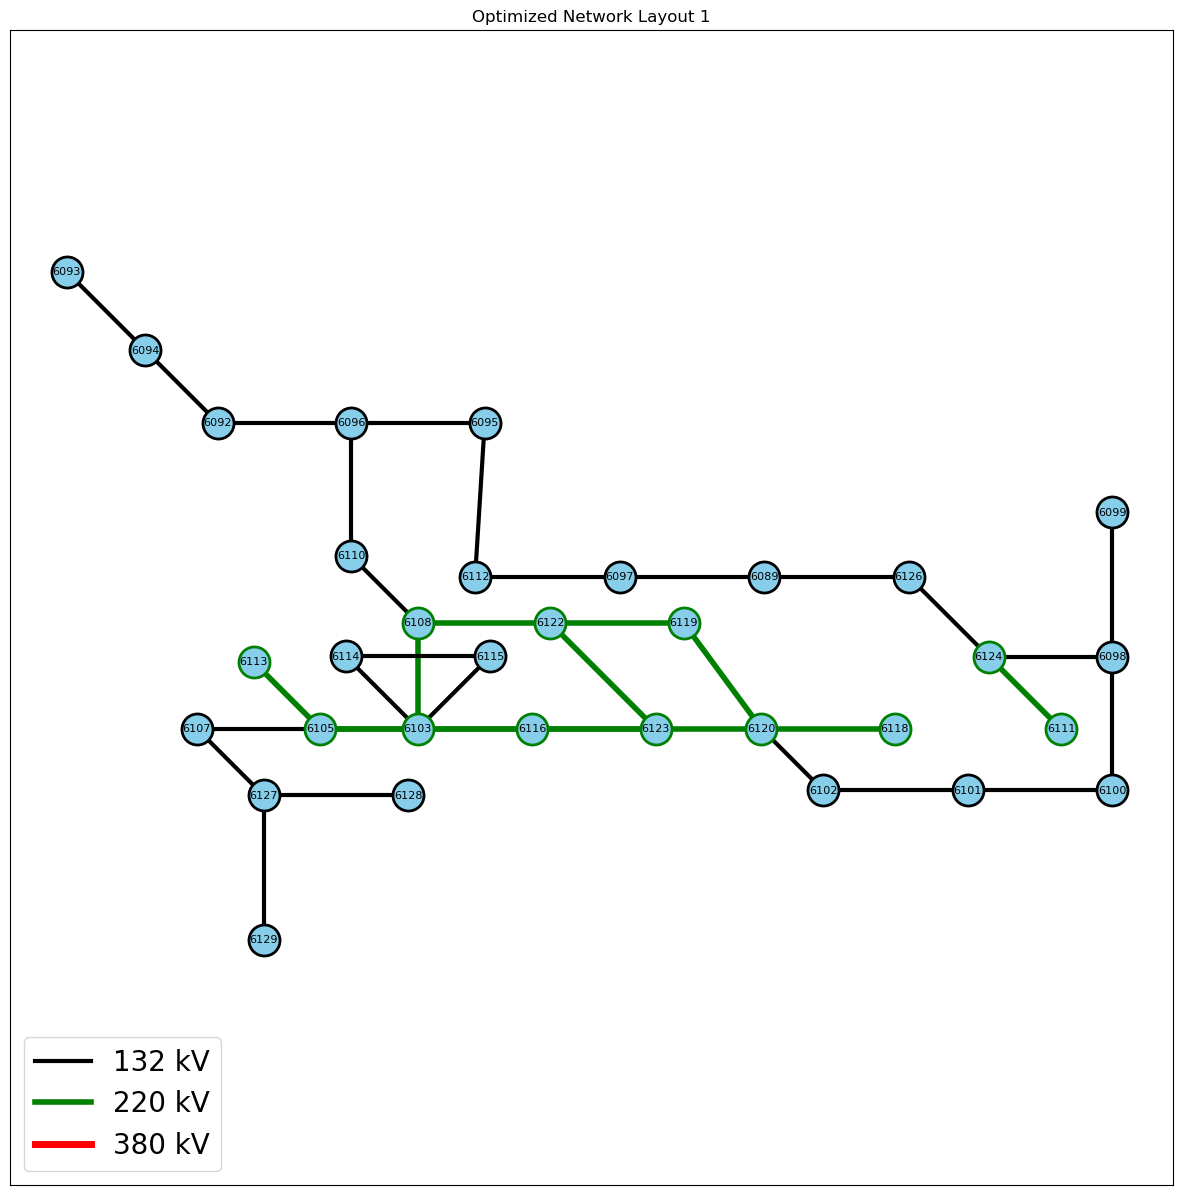

In [2360]:
# Update positions based on optimized x and y coordinates
updated_pos1 = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}


draw_graph(G, updated_pos1, title="Optimized Network Layout 1")

In [2361]:
opt_edges_info = []

# Iterate through each edge in your graph
for edge in G.edges():
    node1, node2 = edge

    # Retrieve the updated positions for source and destination nodes
    new_src_x, new_src_y = updated_pos1[node1]
    new_dst_x, new_dst_y = updated_pos1[node2]

    # Calculate the angle using the updated positions
    angle = calculate_angle(new_src_x, new_src_y, new_dst_x, new_dst_y)

    formatted_angle = round(angle, 2)

    # Append the edge information and formatted angle to the list
    opt_edges_info.append({
        'Edge': edge,
        'Source': node1,
        'Destination': node2,
        'Angle (degrees)': formatted_angle  # Use the formatted angle
    })

# Convert the list of dictionaries to a pandas DataFrame for easy tabular display
opt_edges_info_df = pd.DataFrame(opt_edges_info)

# Print the DataFrame

display(opt_edges_info_df)

,Edge,Source,Destination,Angle (degrees)
0,"(6093, 6094)",6093,6094,315.00
1,"(6107, 6127)",6107,6127,315.00
2,"(6127, 6128)",6127,6128,0.00
3,"(6127, 6129)",6127,6129,270.00
4,"(6089, 6126)",6089,6126,0.00
5,"(6089, 6097)",6089,6097,180.00
6,"(6124, 6126)",6124,6126,135.00
7,"(6098, 6124)",6098,6124,180.00
8,"(6098, 6100)",6098,6100,270.00
9,"(6098, 6099)",6098,6099,90.00


## Circular Order Constraint

In [2362]:
# Beta Binary Sum Constraint


def beta_sum_constraint_rule(model, node):
    # Ensure we use 0-based indexing to match the updated indexing in Beta
    # Note that RangeSet in Pyomo starts from 1, so we adjust the range accordingly
    return sum(model.Beta[node, index] for index in range(0, len(model.OrderedNeighbours[node]) )) == 1

model.BetaSumConstraint = Constraint(model.NodesWith2Neighbours, rule=beta_sum_constraint_rule, doc = "Circle Binary Constraint")




# Define the ConstraintList in your Pyomo model
model.OrderMaintenanceConstraints = ConstraintList(doc = "Circle Order Constraints")


def add_order_maintenance_constraints(model):
    for node, neighbours in ordered_neighbours_dict.items():
        num_neighbours = len(neighbours)
        
        
        for index in range(num_neighbours):
            print(index)
            # Handle all neighbor pairs except the last pair (which wraps around)
            if index < num_neighbours - 1:
                next_index = index + 1
            else:
                next_index = 0      # wrap around case
                
                
            # Use the helper function to dynamically select dir_forward or dir_backward
            dir_sect = node_neighbour_direction(model, node, neighbours[index])
            next_dir_sect = node_neighbour_direction(model, node, neighbours[next_index])
            
            # Debugging prints before adding the constraint
            print(f"Node: {node}, Neighbour: {neighbours[index]}, Directional Sector: {dir_sect}")
            print(f"Node: {node}, Next Neighbour: {neighbours[next_index]}, Next Directional Sector: {next_dir_sect}")
            if index == num_neighbours - 1:  # For wrap-around case
                print(f"\nNode: {node}, Index: {index}, Beta: {model.Beta[node, index].value if model.Beta[node, index].value is not None else 'Not solved yet'}")

            
            
            if dir_sect is not None and next_dir_sect is not None:
                    model.OrderMaintenanceConstraints.add(dir_sect <= next_dir_sect - 1 + 8*model.Beta[node, index])

                

            
           
# Call the function to add the constraints to the ConstraintList
add_order_maintenance_constraints(model)   

0
Node: 6094, Neighbour: 6093, Directional Sector: dir_backward[6093,6094]
Node: 6094, Next Neighbour: 6092, Next Directional Sector: dir_backward[6092,6094]
1
Node: 6094, Neighbour: 6092, Directional Sector: dir_backward[6092,6094]
Node: 6094, Next Neighbour: 6093, Next Directional Sector: dir_backward[6093,6094]

Node: 6094, Index: 1, Beta: Not solved yet
0
Node: 6107, Neighbour: 6105, Directional Sector: dir_backward[6105,6107]
Node: 6107, Next Neighbour: 6127, Next Directional Sector: dir_forward[6107,6127]
1
Node: 6107, Neighbour: 6127, Directional Sector: dir_forward[6107,6127]
Node: 6107, Next Neighbour: 6105, Next Directional Sector: dir_backward[6105,6107]

Node: 6107, Index: 1, Beta: Not solved yet
0
Node: 6127, Neighbour: 6128, Directional Sector: dir_forward[6127,6128]
Node: 6127, Next Neighbour: 6107, Next Directional Sector: dir_backward[6107,6127]
1
Node: 6127, Neighbour: 6107, Directional Sector: dir_backward[6107,6127]
Node: 6127, Next Neighbour: 6129, Next Directional

In [2363]:
solver.solve(model, tee=True, warmstart=True)
# Assuming 'results' contains the solver results
print(results.solver.status)
print(results.solver.termination_condition)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file C:\Users\katec\AppData\Local\Temp\tmpt1vcgjbw.pyomo.lp
Reading time = 0.01 seconds
x1: 1065 rows, 698 columns, 3731 nonzeros
Read MIP start from file C:\Users\katec\AppData\Local\Temp\tmpr78lsl70.gurobi.mst
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 4700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1065 rows, 698 columns and 3731 nonzeros
Model fingerprint: 0x35b4621a
Variable types: 140 continuous, 558 integer (382 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e-01, 1e+01]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 3e+04]

User MIP start did not produce a new incumbent solution

Presolve removed 405 rows and 327 columns
Presolve time: 0.02s
Presolved: 660 rows, 3

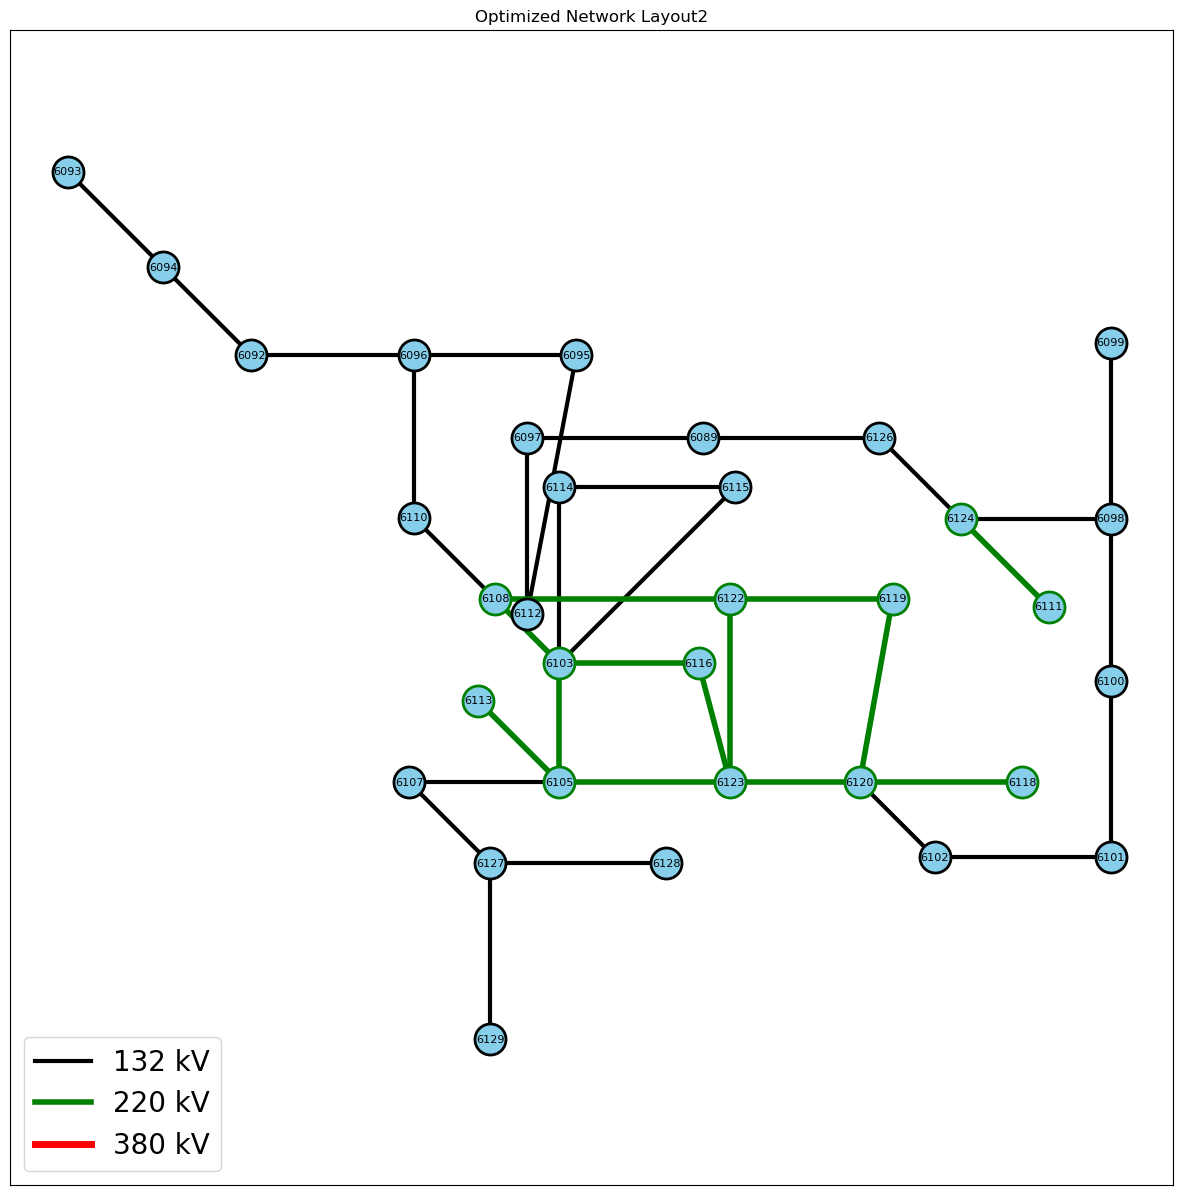

In [2364]:
# Update positions based on optimized x and y coordinates
updated_pos2 = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}




#draw_graph(G, updated_pos)

draw_graph(G, updated_pos2, title="Optimized Network Layout2")

## Edge Spacing Constraint

In [2365]:
def non_incident_edge_direction_constraint_rule(model, u1, v1, u2, v2):
    
    e1 = (u1, v1)
    e2 = (u2, v2)
        
    return (model.is_N[e1, e2] + model.is_S[e1, e2] + model.is_E[e1, e2] + model.is_W[e1, e2] +
            model.is_NE[e1, e2] + model.is_NW[e1, e2] + model.is_SE[e1, e2] + model.is_SW[e1, e2] >= 1)
    
#model.NonIncidentEdgeDirectionConstraint = Constraint(model.NonIncidentEdges, rule=non_incident_edge_direction_constraint_rule)
model.NonIncidentEdgeDirectionConstraint = Constraint(model.NonIntersecting_NonIncidentEdges, rule=non_incident_edge_direction_constraint_rule, doc = "NSEW Constraint")





#tolerance_factor = 0.25  # This defines a 10% tolerance, adjust as needed


# Initialize ConstraintList outside of function
# Adds new constraints to list in model without reinitializing it
model.edgeSpacingConstraints = ConstraintList(doc = "Edge Spacing Constraint")

def edge_spacing_constraint(model, u1, v1, u2, v2):
    
    
    e1 = (u1, v1)
    e2 = (u2, v2)
    
    
    #dmin = min_edge_spacing
    #dmin = model.dynamicMinSpacings[e1]    ## infeasibility coming from too small M value due to large distances between
    dmin = model.dynamicMinSpacings[e1] 
    #dmin = 400
    M = 30000
    
    
    
    
    # is_N[e1, e2] means that e1 is north of e1
    
    ## North Constraint
    c1 = model.y_pos[u2] - model.y_pos[u1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c2 = model.y_pos[v2] - model.y_pos[u1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c3 = model.y_pos[u2] - model.y_pos[v1] <= M * (1 - model.is_N[e1, e2]) - dmin
    c4 = model.y_pos[v2] - model.y_pos[v1] <= M * (1 - model.is_N[e1, e2]) - dmin

    
    # South
    c5 = model.y_pos[u1] - model.y_pos[u2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c6 = model.y_pos[v1] - model.y_pos[u2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c7 = model.y_pos[u1] - model.y_pos[v2] <= M * (1 - model.is_S[e1, e2]) - dmin
    c8 = model.y_pos[v1] - model.y_pos[v2] <= M * (1 - model.is_S[e1, e2]) - dmin

    
    # is_E[e1, e2] = 1 means that e1 is East of e2
    ## East
    c9 = model.x_pos[u2] - model.x_pos[u1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c10 = model.x_pos[v2] - model.x_pos[u1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c11 = model.x_pos[u2] - model.x_pos[v1] <= M * (1 - model.is_E[e1, e2]) - dmin
    c12 = model.x_pos[v2] - model.x_pos[v1] <= M * (1 - model.is_E[e1, e2]) - dmin

    
    
    
    ## West
    c13 = model.x_pos[u1] - model.x_pos[u2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c14 = model.x_pos[v1] - model.x_pos[u2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c15 = model.x_pos[u1] - model.x_pos[v2] <= M * (1 - model.is_W[e1, e2]) - dmin
    c16 = model.x_pos[v1] - model.x_pos[v2] <= M * (1 - model.is_W[e1, e2]) - dmin

    
    
    ## NE
    c17 = (model.x_pos[u2] + model.y_pos[u2]) - (model.x_pos[u1] + model.y_pos[u1]) <= M * (1 - model.is_NE[e1, e2]) - dmin
    c18 = (model.x_pos[v2] + model.y_pos[v2]) - (model.x_pos[u1] + model.y_pos[u1]) <= M * (1 - model.is_NE[e1, e2]) - dmin
    c19 = (model.x_pos[u2] + model.y_pos[u2]) - (model.x_pos[v1] + model.y_pos[v1]) <= M * (1 - model.is_NE[e1, e2]) - dmin
    c20 = (model.x_pos[v2] + model.y_pos[v2]) - (model.x_pos[v1] + model.y_pos[v1]) <= M * (1 - model.is_NE[e1, e2]) - dmin

    
    
    ## NW
    c21 = (model.x_pos[u1] - model.y_pos[u1]) - (model.x_pos[u2] - model.y_pos[u2]) <= M * (1 - model.is_NW[e1, e2]) - dmin
    c22 = (model.x_pos[u1] - model.y_pos[u1]) - (model.x_pos[v2] - model.y_pos[v2]) <= M * (1 - model.is_NW[e1, e2]) - dmin
    c23 = (model.x_pos[v1] - model.y_pos[v1]) - (model.x_pos[u2] - model.y_pos[u2]) <= M * (1 - model.is_NW[e1, e2]) - dmin
    c24 = (model.x_pos[v1] - model.y_pos[v1]) - (model.x_pos[v2] - model.y_pos[v2]) <= M * (1 - model.is_NW[e1, e2]) - dmin

    
    
    # SE
    c25 = (model.x_pos[u2] - model.y_pos[u2]) - (model.x_pos[u1] - model.y_pos[u1]) <= M * (1 - model.is_SE[e1, e2]) - dmin
    c26 = (model.x_pos[v2] - model.y_pos[v2]) - (model.x_pos[u1] - model.y_pos[u1]) <= M * (1 - model.is_SE[e1, e2]) - dmin
    c27 = (model.x_pos[u2] - model.y_pos[u2]) - (model.x_pos[v1] - model.y_pos[v1]) <= M * (1 - model.is_SE[e1, e2]) - dmin
    c28 = (model.x_pos[v2] - model.y_pos[v2]) - (model.x_pos[v1] - model.y_pos[v1]) <= M * (1 - model.is_SE[e1, e2]) - dmin

    
    
    
    
    ## SW
    c29 = (model.x_pos[u1] + model.y_pos[u1]) - (model.x_pos[u2] + model.y_pos[u2]) <= M * (1 - model.is_SW[e1, e2]) - dmin
    c30 = (model.x_pos[u1] + model.y_pos[u1]) - (model.x_pos[v2] + model.y_pos[v2]) <= M * (1 - model.is_SW[e1, e2]) - dmin
    c31 = (model.x_pos[v1] + model.y_pos[v1]) - (model.x_pos[u2] + model.y_pos[u2]) <= M * (1 - model.is_SW[e1, e2]) - dmin
    c32 = (model.x_pos[v1] + model.y_pos[v1]) - (model.x_pos[v2] + model.y_pos[v2]) <= M * (1 - model.is_SW[e1, e2]) - dmin

    
    constraint_list = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18, c19, c20, c21, c22, c23, c24, c25, c26, c27, c28, c29, c30, c31, c32]

    # Add all constraints to the constraint list
    for constraint in constraint_list:
        model.edgeSpacingConstraints.add(constraint)
 
 
 

           
# Call edge_spacing_constraint for each non-incident edge pair
for u1, v1, u2, v2 in model.NonIntersecting_NonIncidentEdges :
    edge_spacing_constraint(model, u1, v1, u2, v2)
        

# Solver - Final

In [2366]:
solver.solve(model, tee=True, warmstart=True)

results = solver.solve(model, tee=True, warmstart=True)

# Assuming 'results' contains the solver results
print(results.solver.status)
print(results.solver.termination_condition)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file C:\Users\katec\AppData\Local\Temp\tmpwz0w264v.pyomo.lp
Reading time = 0.08 seconds
x1: 20964 rows, 5522 columns, 85739 nonzeros
Read MIP start from file C:\Users\katec\AppData\Local\Temp\tmphkudyz3w.gurobi.mst
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 4700U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20964 rows, 5522 columns and 85739 nonzeros
Model fingerprint: 0xe9490891
Variable types: 140 continuous, 5382 integer (5206 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e-01, 1e+01]
  Bounds range     [1e+00, 7e+00]
  RHS range        [1e+00, 3e+04]

User MIP start did not produce a new incumbent solution

Presolve removed 501 rows and 360 columns
Presolve time: 0.26s
Presolved: 204

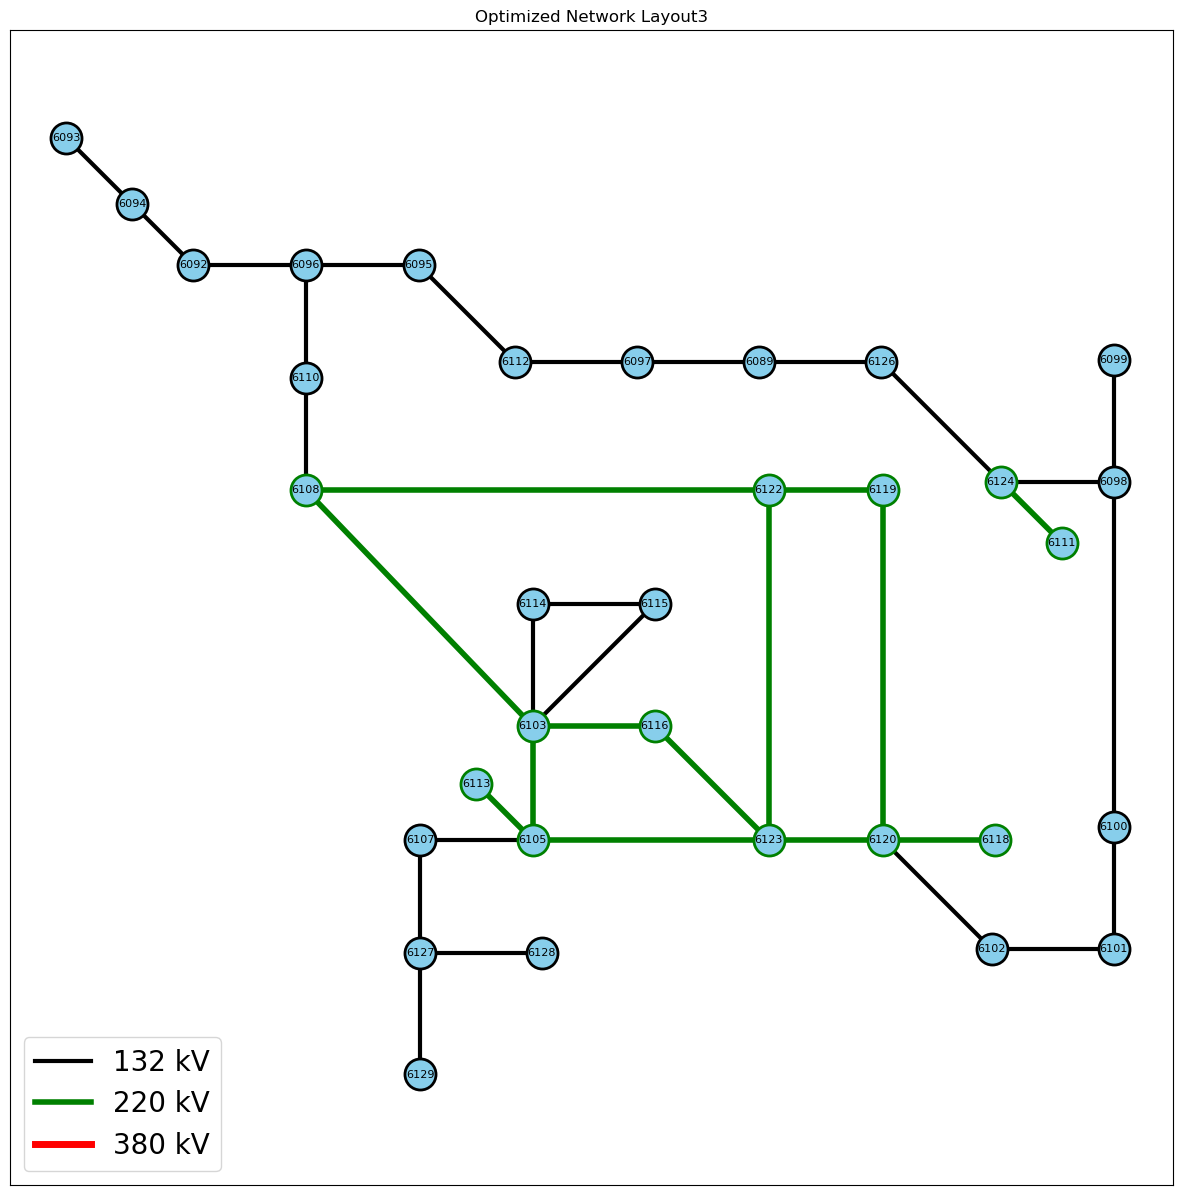

In [2367]:
# Update positions based on optimized x and y coordinates
updated_pos3 = {node: (value(model.x_pos[node]), value(model.y_pos[node])) for node in G.nodes()}



draw_graph(G, updated_pos3, title="Optimized Network Layout3")

In [2368]:
opt_edges_info = []

# Iterate through each edge in your graph
for edge in G.edges():
    node1, node2 = edge

    # Retrieve the updated positions for source and destination nodes
    new_src_x, new_src_y = updated_pos3[node1]
    new_dst_x, new_dst_y = updated_pos3[node2]

    # Calculate the angle using the updated positions
    angle = calculate_angle(new_src_x, new_src_y, new_dst_x, new_dst_y)

    formatted_angle = round(angle, 2)

    # Append the edge information and formatted angle to the list
    opt_edges_info.append({
        'Edge': edge,
        'Source': node1,
        'Destination': node2,
        'Angle (degrees)': formatted_angle  # Use the formatted angle
    })

# Convert the list of dictionaries to a pandas DataFrame for easy tabular display
opt_edges_info_df = pd.DataFrame(opt_edges_info)

# Print the DataFrame
#print(edges_info_df)
display(opt_edges_info_df)

,Edge,Source,Destination,Angle (degrees)
0,"(6093, 6094)",6093,6094,315.00
1,"(6107, 6127)",6107,6127,270.00
2,"(6127, 6128)",6127,6128,0.00
3,"(6127, 6129)",6127,6129,270.00
4,"(6089, 6126)",6089,6126,360.00
5,"(6089, 6097)",6089,6097,180.00
6,"(6124, 6126)",6124,6126,135.00
7,"(6098, 6124)",6098,6124,180.00
8,"(6098, 6100)",6098,6100,270.00
9,"(6098, 6099)",6098,6099,90.00


# Results - Summary

In [2369]:

def extract_solver_stats(results, df):
    stats = {
        'Solver Status': str(results.solver.status),
        'Termination Condition': str(results.solver.termination_condition),
        'Solve Time (s)': f"{results.solver.time:.2f}",
        'Number of Constraints': results.problem.number_of_constraints,
        'Number of Variables': results.problem.number_of_variables,
        'Number of Nonzeros': results.problem.number_of_nonzeros
    }
    if results.solver.status == 'ok' and results.solver.termination_condition == 'optimal':
        obj_val = value(model.Objective.expr)
        stats['Objective Value'] = f"{obj_val:.2f}" if isinstance(obj_val, float) else int(obj_val)
   
    else:
        stats['Objective Value'] = 'N/A'
        
    all_nodes = pd.concat([df['src_bus_id'], df['dst_bus_id']]).unique()
    stats['Total Number of Nodes'] = len(all_nodes)
    
    stats['Total Number of Edges'] = len(df)
    
    
    return stats
stats = extract_solver_stats(results, country_df)

In [2370]:
def count_octilinearity_violations(opt_edges_info):
    violations = []
    for edge_info in opt_edges_info:
        edge = edge_info['Edge']
        angle = edge_info['Angle (degrees)']
        if angle % 45 != 0:
            print(f"Violation found: {edge} with angle {angle}°")
            violations.append(edge)  # Add the edge tuple to the list
    if not violations:
        print("No violations found.")
    else:
        print(f"Total Octilinear Violations: {len(violations)}")
    return violations



octilinearity_violations = count_octilinearity_violations(opt_edges_info)

Violation found: (6103, 6108) with angle 133.86°
Total Octilinear Violations: 1


In [2371]:
def get_sorted_neighbours(G, node, pos, initial_neighbour):
    angles_neighbours = []
    src_x, src_y = pos[node]

    # Convert G to an undirected graph to consider all adjacent nodes
    G_undirected = G.to_undirected()

    # Calculate angles and sort neighbours
    for neighbour in G_undirected.neighbors(node):
        dst_x, dst_y = pos[neighbour]
        angle = calculate_angle(src_x, src_y, dst_x, dst_y)
        angles_neighbours.append((angle, neighbour))

    angles_neighbours.sort()
    sorted_neighbours = [neighbour for _, neighbour in angles_neighbours]

    # Start the sorted list with the initial neighbour
    if initial_neighbour in sorted_neighbours:
        start_index = sorted_neighbours.index(initial_neighbour)
        sorted_neighbours = sorted_neighbours[start_index:] + sorted_neighbours[:start_index]

    return sorted_neighbours

def check_order_and_sector_violations(G, updated_pos, ordered_neighbours_dict):
    order_violations = []
    sector_violations = []
    
    for node, initial_neighbours in ordered_neighbours_dict.items():
        if initial_neighbours:  # Make sure there is at least one neighbour
            initial_first_neighbour = initial_neighbours[0]
            optimized_neighbours = get_sorted_neighbours(G, node, updated_pos3, initial_first_neighbour)
            
            # Check for order violations
            if initial_neighbours != optimized_neighbours:
                print(f"Order violation at node {node}. Initial order: {initial_neighbours}, Optimized order: {optimized_neighbours}")
                order_violations.append((node, initial_first_neighbour))
            
            
            
            
            
            # Check for sector violations
            angles = [round(calculate_angle(updated_pos[node][0], updated_pos[node][1],
                                            updated_pos[neighbour][0], updated_pos[neighbour][1]), 1)
                      for neighbour in optimized_neighbours]
            sectors = [int(angle // 45) for angle in angles]
            for i in range(len(sectors) - 1):
                if sectors[i] == sectors[i + 1] and angles[i] != angles[i + 1]:
                    print(f"Sector violation between nodes {optimized_neighbours[i]} and {optimized_neighbours[i + 1]} "
                          f"at node {node} in sector {sectors[i]}. Rounded angles: {angles[i]}, {angles[i + 1]}")
                    sector_violations.append((node, optimized_neighbours[i]))
                    break  # Stop at the first violation for this node


    if (len(order_violations) + len(sector_violations)) == 0:

    
        print("No circular order violations found.")
    else:
        print(f"Total circular order violations: {len(order_violations)}")
        print(f"Total sector violations: {len(sector_violations)}")

    
    return order_violations, sector_violations

# Example usage
circular_order_violations = check_order_and_sector_violations(G, updated_pos3, ordered_neighbours_dict)


Sector violation between nodes 6114 and 6108 at node 6103 in sector 2. Rounded angles: 90.0, 133.9
Total circular order violations: 0
Total sector violations: 1


In [2372]:

def check_edge_crossing_violations(specified_edge_pairs, pos):
    intersecting_edge_pairs = []
    crossing_violations = []

    for edge1, edge2 in specified_edge_pairs:
        # Get the positions for the source and target nodes of each edge from the 'pos' argument
        src_pos1, tgt_pos1 = pos[edge1[0]], pos[edge1[1]]
        src_pos2, tgt_pos2 = pos[edge2[0]], pos[edge2[1]]
        
        # Create LineString objects for each edge
        line1 = LineString([src_pos1, tgt_pos1])
        line2 = LineString([src_pos2, tgt_pos2])

        # Check if the two edges intersect and are not merely touching at endpoints
        if line1.intersects(line2) and not line1.touches(line2):
            print(f"Violation found between edge {edge1} and edge {edge2}")
            intersecting_edge_pairs.append((edge1, edge2))
            crossing_violations.append((edge1, edge2))

    if len(crossing_violations) == 0:
        print("No edge crossing violations found.")
    else:
        print(f"Total edge crossing violations: {len(crossing_violations)}")

    return crossing_violations


edge_cross_violations = check_edge_crossing_violations(non_intersecting_non_incident_edges, updated_pos3)


No edge crossing violations found.


In [2373]:
octilinearity_violations = count_octilinearity_violations(opt_edges_info)
print("\n")
order_violations, sector_violations = check_order_and_sector_violations(G, updated_pos3, ordered_neighbours_dict)
print("\n")
edge_cross_violations = check_edge_crossing_violations(non_intersecting_non_incident_edges, updated_pos3)


Violation found: (6103, 6108) with angle 133.86°
Total Octilinear Violations: 1


Sector violation between nodes 6114 and 6108 at node 6103 in sector 2. Rounded angles: 90.0, 133.9
Total circular order violations: 0
Total sector violations: 1


No edge crossing violations found.


In [2374]:
# Initialize a dictionary to hold edge violations
edge_violations = {}

# Update edge_violations with details
for edge in octilinearity_violations:
    edge_violations.setdefault(edge, []).append('Octilinearity')

for edge in order_violations:
    edge_violations.setdefault(edge, []).append('Order')

""" for edge in sector_violations:
    edge_violations.setdefault(edge, []).append('Sector') """

for edge in edge_cross_violations:
    edge_violations.setdefault(edge, []).append('Edge Spacing')

# Now, create a DataFrame from the edge_violations dictionary
# Convert the keys to a string representation of edge pairs and the values to a string of violations
df_violations = pd.DataFrame(
    [(str(key), ', '.join(value)) for key, value in edge_violations.items()],
    columns=['Edge Pair', 'Violations']
)

# Show the DataFrame as a table
display(df_violations)


,Edge Pair,Violations
0,"(6103, 6108)",Octilinearity


In [2375]:

def display_results(stats, octilinearity_violations, circular_order_violations, edge_crossing_violations):
    # Construct the results DataFrame with the specified metrics
    results_df = pd.DataFrame([
        ['Solver Status', stats.get('Solver Status', 'N/A')],
        ['Objective Function Value', stats.get('Objective Value', 'N/A')],
        ['Computation Time (s)', stats.get('Solve Time (s)', 'N/A')],
        
        ['Number of Constraints', stats.get('Number of Constraints', 'N/A')],
        ['Number of Variables', stats.get('Number of Variables', 'N/A')],
        
        ['Total Number of Nodes', stats.get('Total Number of Nodes', 'N/A')],
        ['Total Number of Edges', stats.get('Total Number of Edges', 'N/A')],
        
        ['Octilinearity Violations', len(octilinearity_violations)],
        ['Circular Order Violations', len(circular_order_violations)],
        ['Edge Crossing Violations', len(edge_crossing_violations)]
    ], columns=['Metric', 'Value'])
    
    # Display the DataFrame
    # If using a Jupyter Notebook, 'display()' will work directly.
    # In other environments, you might need to print the DataFrame or use another method to visualize it.
    display(results_df)

In [2376]:
stats = extract_solver_stats(results, country_df)


display_results(stats, octilinearity_violations, order_violations, edge_cross_violations)

,Metric,Value
0,Solver Status,ok
1,Objective Function Value,1956.25
2,Computation Time (s),90.65
3,Number of Constraints,20964
4,Number of Variables,5522
5,Total Number of Nodes,33
6,Total Number of Edges,39
7,Octilinearity Violations,1
8,Circular Order Violations,0
9,Edge Crossing Violations,0


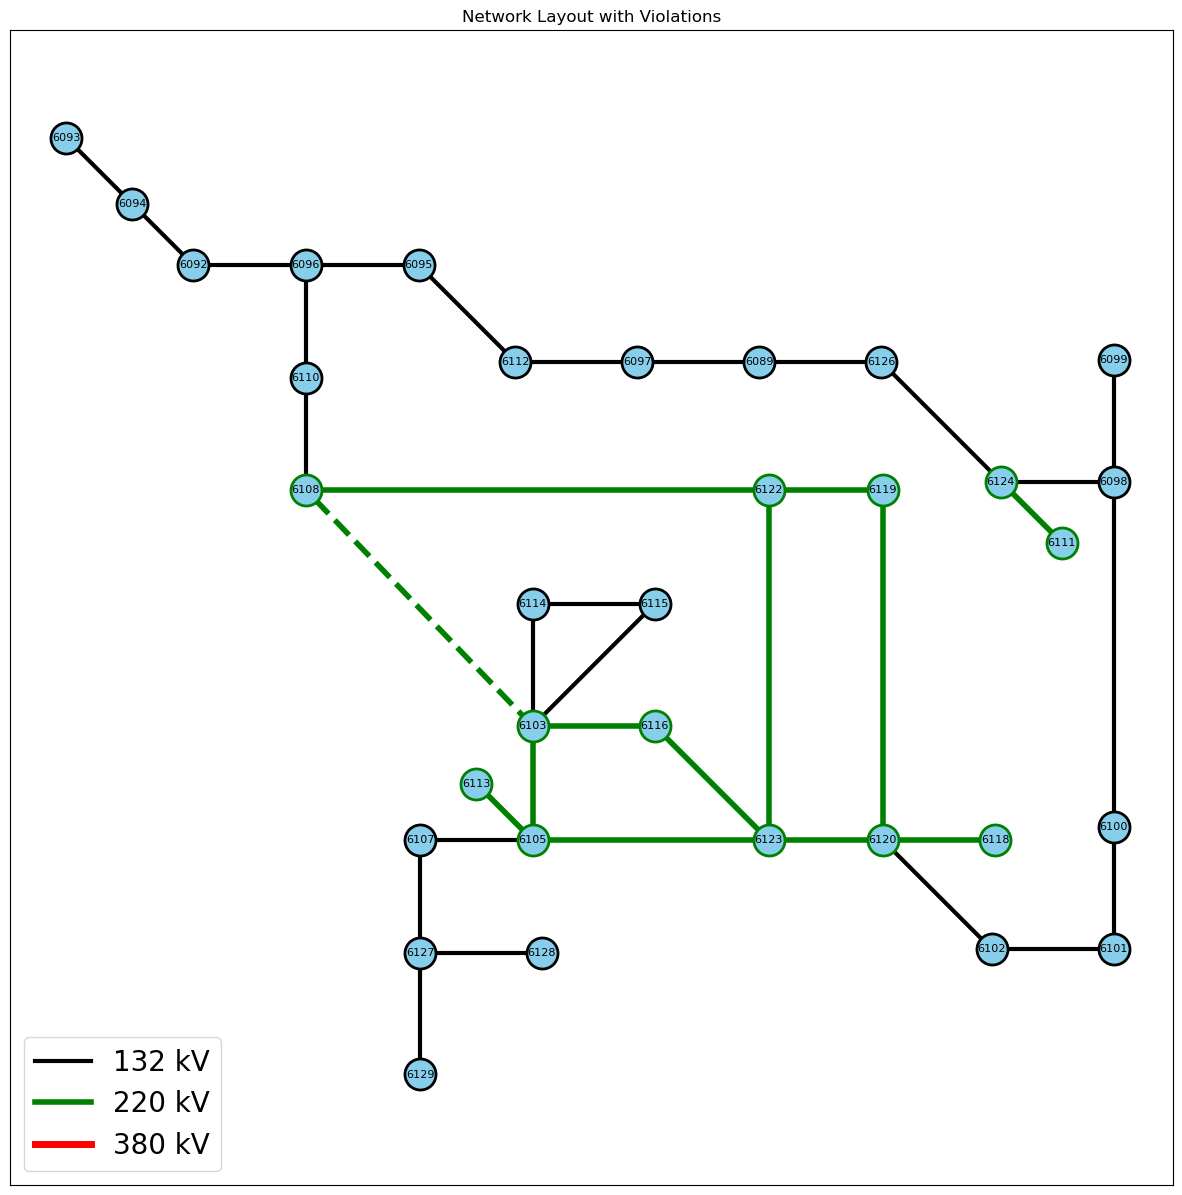

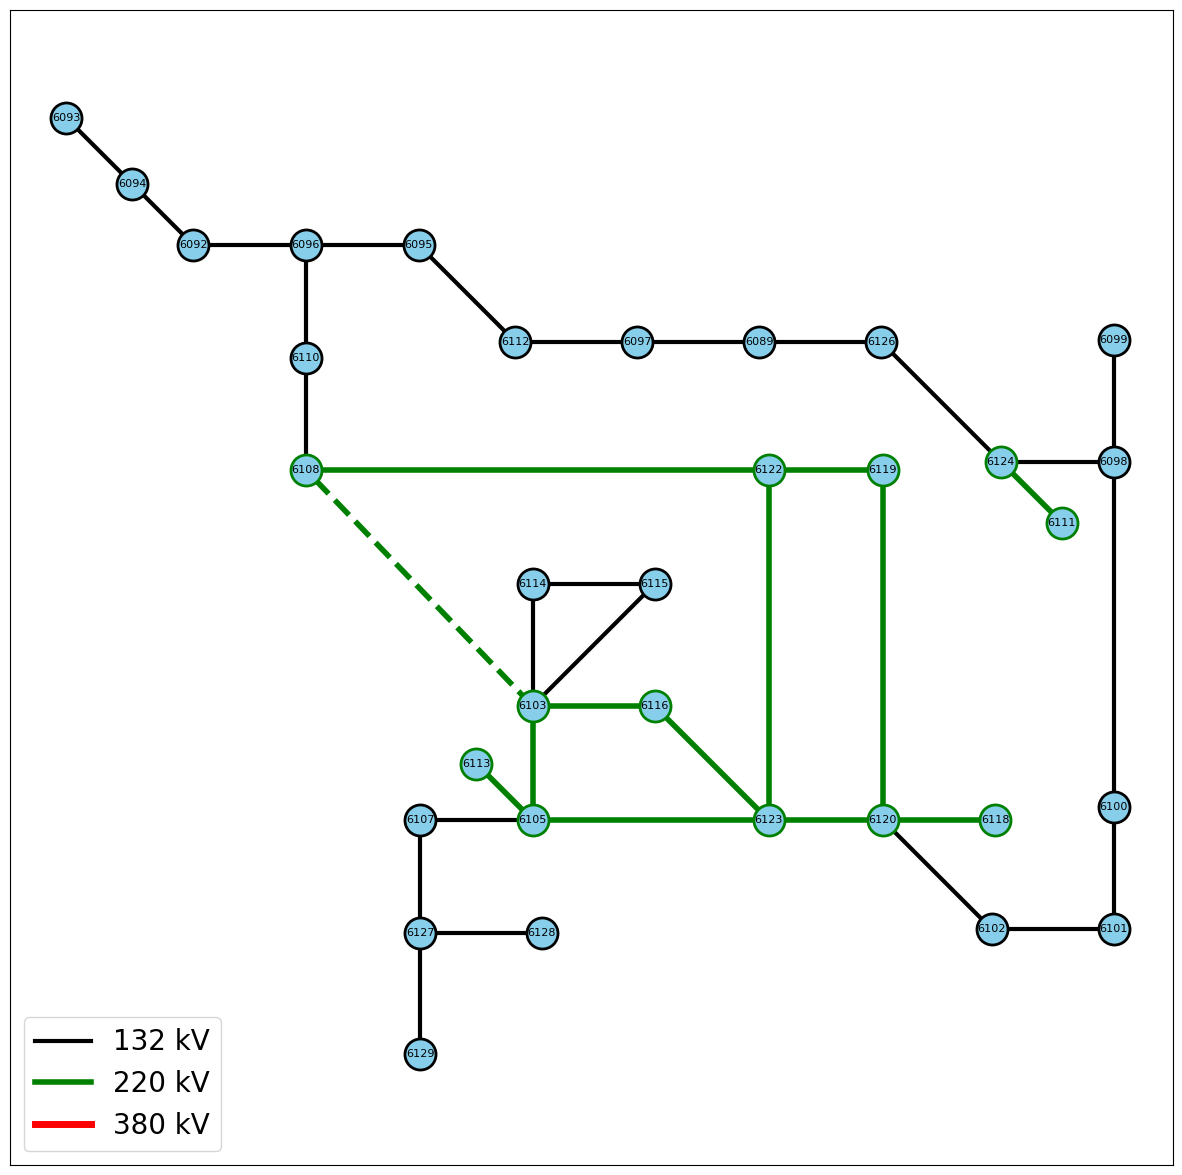

In [2379]:
# Combine all violated edges into one list
all_violated_edges = octilinearity_violations + order_violations  + edge_cross_violations

# Remove duplicates if there are any, by converting to a set and back to a list
all_violated_edges = list(set(all_violated_edges))

# Now pass this list to the draw_graph function
draw_graph(G, updated_pos3, violations=all_violated_edges, title="Network Layout with Violations")
draw_graph(G, updated_pos3, violations=all_violated_edges)

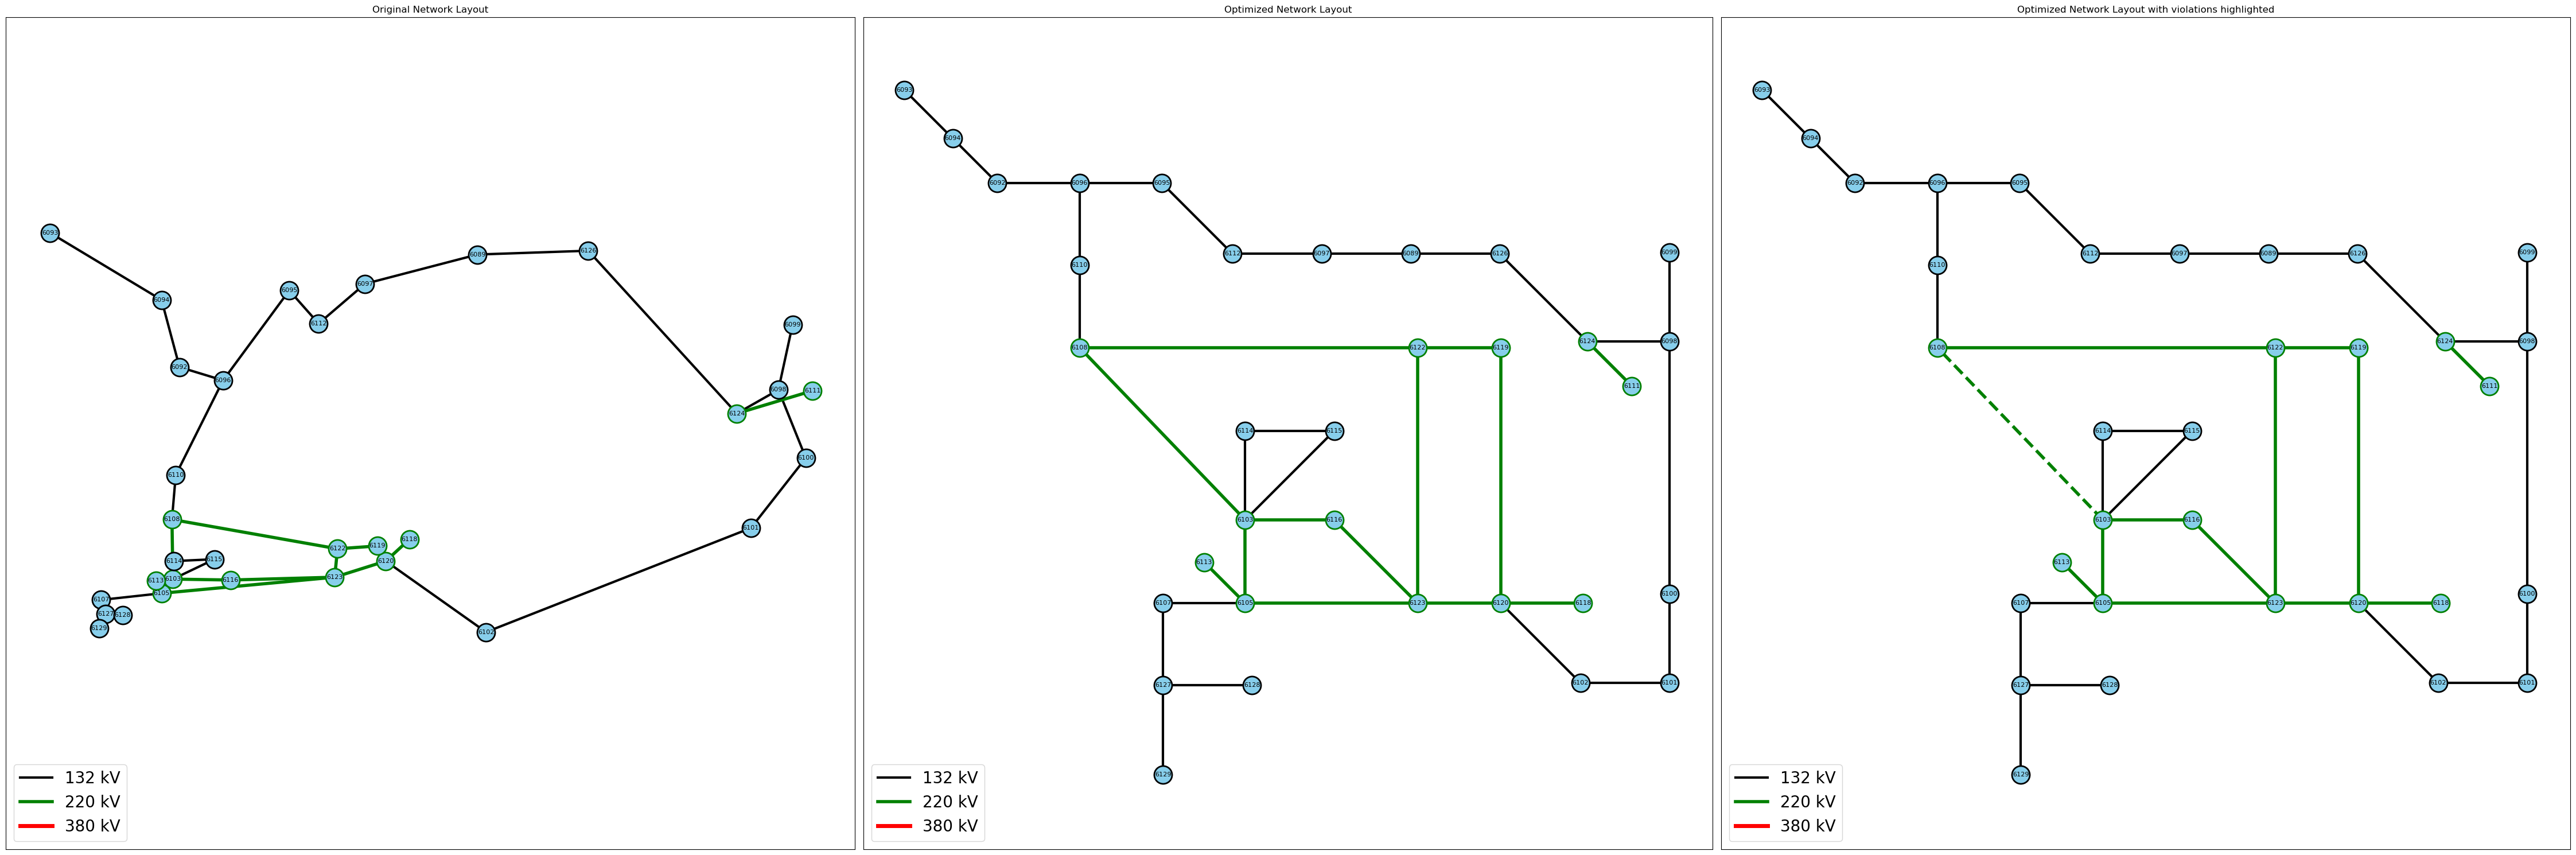

In [2378]:
# Now create a subplot with both the original and optimized graphs side by side
fig, axs = plt.subplots(1, 3, figsize=(45, 15))  # 1 row, 2 columns for the subplots

# Draw the original graph on the first subplot
draw_graph(G, pos, ax=axs[0], title="Original Network Layout")

draw_graph(G, updated_pos3, ax=axs[1], title="Optimized Network Layout")

# Draw the optimized graph on the second subplot
draw_graph(G, updated_pos3, violations=all_violated_edges, ax=axs[2], title="Optimized Network Layout with violations highlighted")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the combined plot
plt.show()